In [1]:
import numpy as np

class Model(object):
    def __init__(self):
        '''
        Abstract class defining which functions a model should have
        '''
        self.model = None

    def fit(self, X, y, verbose=0):
        raise NotImplemented

    def predict(self, X, a):
        raise NotImplemented

    def all_actions(self, X):
        raise NotImplemented

    def representation(*args):
        raise NotImplemented

    def copy_over_to(self, to_):
        to_.model.set_weights(self.model.get_weights())

    def evaluate(self, verbose=False, render=False, **kw):
        return self.policy_evalutor.run(self, verbose=verbose, render=render, **kw)

    def min_over_a(self, X, randomized_tiebreaking=False, **kw):
        '''
        Returns min_a Q(X,a), argmin_a Q(X,a)
        '''
        Q_x_a = self.all_actions(X, **kw)
        return self.min_and_argmin(Q_x_a, randomized_tiebreaking, axis=1)

    def max_over_a(self, X, randomized_tiebreaking=False, **kw):
        '''
        Returns min_a Q(X,a), argmin_a Q(X,a)
        '''

        Q_x_a = self.all_actions(X, **kw)
        return self.max_and_argmax(Q_x_a, randomized_tiebreaking, axis=1)

    @staticmethod
    def max_and_argmax(Q, randomized_tiebreaking=False, **kw):
        ''' max + Argmax + Breaks max/argmax ties randomly'''
        if not randomized_tiebreaking:
            return np.max(Q, **kw), np.argmax(Q, **kw)
        else:
            tie_breaker = np.random.random(Q.shape) * (Q==Q.max())
            argmax = np.argmax(tie_breaker, **kw) # this is counter intuitive.
            return Q[np.arange(Q.shape[0]), argmax], argmax

    @staticmethod
    def min_and_argmin(Q, randomized_tiebreaking=False, **kw):
        ''' min + Argmin + Breaks min/argmin ties randomly'''
        if not randomized_tiebreaking:
            return np.min(Q, **kw), np.argmin(Q, **kw)
        else:
            tie_breaker = - np.random.random(Q.shape) * (Q==Q.min())
            argmin = np.argmin(tie_breaker, **kw)
            return Q[np.arange(Q.shape[0]), argmin], argmin

    def __call__(self, *args, **kw):
        x_preprocessed = kw['x_preprocessed'] if 'x_preprocessed' in kw else False
        if len(args) == 1:
            '''
            Run policy: pi = argmin_a Q(x,a)
            '''
            x = args[0]
            return self.min_over_a(x, False, x_preprocessed=x_preprocessed)[1]
        elif len(args) == 2:
            '''
            Evaluate Q(x,a)
            '''
            x,a = args
            return self.predict(x,a, x_preprocessed=x_preprocessed)
        else:
            raise

    @staticmethod
    def cartesian_product(*arrays):
        la = len(arrays)
        dtype = np.result_type(*arrays)
        arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
        for i, a in enumerate(np.ix_(*arrays)):
            arr[...,i] = a
        return arr.reshape(-1, la)
    
    # def cartesian_product(x,y):
    #     return np.hstack([np.tile(x.T, y.shape[1]).T, np.tile(y,x.shape[0]).reshape(-1,y.shape[1])])

In [2]:
import numpy as np
import deepdish as dd

class Buffer(object):
    """
    This saves the agent's experience in windowed cache.
    Each frame is saved only once but state is stack of num_frame_stack frames
    In the beginning of an episode the frame-stack is padded
    with the beginning frame
    """

    def __init__(self,
            num_frame_stack=1,
            buffer_size=10000,
            min_buffer_size_to_train=1000,
            pic_size = (96,96),
            action_space_dim = 4,
            n_costs = (),
    ):
        self.n_costs = n_costs
        self.pic_size = pic_size
        self.action_space_dim = action_space_dim
        self.num_frame_stack = num_frame_stack
        self.capacity = buffer_size
        self.counter = -1
        self.exp_idx = -1
        self.frame_window = None
        self.max_frame_cache = self.capacity + 2 * self.num_frame_stack + 1
        self.frame_idx = self.counter % self.max_frame_cache
        self.init_caches()
        self.expecting_new_episode = True
        self.min_buffer_size_to_train = min_buffer_size_to_train
        self.data = {'x':[], 'a':[], 'x_prime':[], 'c':[], 'g':[], 'done':[], 'cost':[]}

    def append(self, action, frame, reward, done):
        assert self.frame_window is not None, "start episode first"
        self.counter += 1
        self.frame_idx = self.counter % self.max_frame_cache
        self.exp_idx = (self.exp_idx + 1) % self.capacity
        
        exp_idx = self.exp_idx
        self.prev_states[exp_idx] = self.frame_window
        self.frame_window = np.append(self.frame_window[1:], self.frame_idx)
        self.next_states[exp_idx] = self.frame_window
        self.actions[exp_idx] = action
        self.is_done[exp_idx] = done
        print('frame---------',frame)
        self.frames[self.frame_idx] = frame
        self.rewards[exp_idx] = reward
        if done:
            self.expecting_new_episode = True

    def start_new_episode(self, frame):
        # it should be okay not to increment counter here
        # because episode ending frames are not used
        assert self.expecting_new_episode, "previous episode didn't end yet"
        self.counter += 1
        self.frame_idx = self.counter % self.max_frame_cache
        self.frame_window = np.repeat(self.frame_idx, self.num_frame_stack)
        self.frames[self.frame_idx] = frame
        self.expecting_new_episode = False

    def is_over(self):
        return self.expecting_new_episode

    def get_length(self):
        return min(self.capacity, self.exp_idx)

    def sample(self, N):
        count = min(self.capacity, self.exp_idx)
        minimum = max(count-40000, 0) # UNHARDCODE THIS. THIS IS FOR USING BUFFER AS SAVER + Exp Replay
        batchidx = np.random.randint(minimum, count, size=N)

        x = self.frames[self.prev_states[batchidx]]
        action = self.actions[batchidx]
        x_prime = self.frames[self.next_states[batchidx]]
        reward = self.rewards[batchidx]
        done = self.is_done[batchidx]
        
        return [x, action, x_prime, reward, done]

    def get_all(self, key):
        valid_states = min(self.capacity, self.exp_idx)
        if key == 'x':
            return self.frames[self.prev_states[:valid_states]]
        elif key == 'a':
            return self.actions[:valid_states]
        elif key == 'x_prime':
            return self.frames[self.next_states[:valid_states]]
        elif key == 'c':
            return self.rewards[:valid_states][:, 0]
        elif key == 'g':
            return self.rewards[:valid_states][:, 1:]
        elif key == 'done':
            return self.is_done[:valid_states]
        elif key == 'cost':
            return []
        elif key == 'frames':
            maximum = max(np.max(self.prev_states[:valid_states]), np.max(self.next_states[:valid_states])) + 1
            return self.frames[:maximum]
        elif key == 'prev_states':
            return self.prev_states[:valid_states]
        elif key == 'next_states':
            return self.next_states[:valid_states]
        else:
            raise
            
    def is_enough(self):
        return self.exp_idx > self.min_buffer_size_to_train

    def current_state(self):
        # assert not self.expecting_new_episode, "start new episode first"'
        assert self.frame_window is not None, "do something first"
        if len(self.pic_size) == 2:
            return np.rollaxis(self.frames[self.frame_window], 0,3)
        else:
            return self.frames[self.frame_window]

    def init_caches(self):
        self.rewards = np.empty((self.capacity,) + self.n_costs, dtype="float64")
        self.prev_states = np.empty((self.capacity, self.num_frame_stack), dtype="uint32")
        self.next_states = np.empty((self.capacity, self.num_frame_stack), dtype="uint32")
        self.is_done = np.empty(self.capacity, "uint8")
        self.actions = np.empty((self.capacity,24), dtype="uint8")
        self.frames = np.empty((self.max_frame_cache,24) + self.pic_size, dtype="uint8")

    def get_state_action_pairs(self, env_type='lake'):
        if 'state_action' in self.data:
            return self.data['state_action']
        else:
            if env_type == 'lake':
                pairs = [np.array(self.data['x']), np.array(self.data['a']).reshape(1,-1).T ]
            elif env_type == 'car':
                pairs = [np.array(self.data['x']), np.array(self.data['a']).reshape(1,-1).T ]
            self.data['state_action'] = pairs

    def calculate_cost(self, lamb):
        self.scale = np.max(np.abs(np.array(self.data['c'] + np.dot(lamb[:-1], np.array(self.data['g']).T))))
        costs = np.array(self.data['c'] + np.dot(lamb[:-1], np.array(self.data['g']).T))/self.scale


        # costs = costs/np.max(np.abs(costs))
        self.data['cost'] = costs.tolist()

    def set_cost(self, key, idx=None):
        if key == 'g': assert idx is not None, 'Evaluation must be done per constraint until parallelized'

        if key == 'c':
            self.scale = np.max(np.abs(self.data['c']))
            self.data['cost'] = self.data['c']/self.scale
        elif key == 'g':
            # Pick the idx'th constraint
            self.scale = np.max(np.abs(self.data['g'][:,idx]))
            self.data['cost'] = self.data['g'][:,idx]/self.scale
        else:
            raise

    def preprocess(self, env_type):

        for key in self.data:
            self.data[key] = self.get_all(key)

    def save(self, path):
        #data = {'frames':self.frames, 'prev_states':self.prev_states, 'next_states':self.next_states, 'rewards':self.rewards, 'is_done':self.is_done, 'actions':self.actions}
        #for data, key in zip([self.frames, self.prev_states, self.next_states, self.rewards, self.is_done, self.actions],['frames', 'prev_astates', 'next_states', 'costs', 'is_done', 'actions'])
        #       dd.io.save(path % key, data)
        count = min(self.capacity, self.counter)
        dd.io.save(path.format('frames'), self.frames[:count])
        dd.io.save(path.format('prev_states'), self.prev_states[:count])
        dd.io.save(path.format('next_states'), self.next_states[:count])
        dd.io.save(path.format('rewards'), self.rewards[:count])
        dd.io.save(path.format('is_done'), self.is_done[:count])
        dd.io.save(path.format('actions'), self.actions[:count])



class Dataset(Buffer):
    def __init__(self, num_frame_stack, pic_size, n_costs):
        
        self.pic_size = pic_size
        self.num_frame_stack = num_frame_stack
        self.data = {'frames':[], 'prev_states':[], 'a':[], 'next_states':[], 'c':[], 'g':[], 'done':[], 'cost':[], 'x_prime_repr':[], 'x_repr':[]}
        self.max_trajectory_length = 0
        self.n_costs = n_costs
        self.episodes = [Buffer(num_frame_stack=self.num_frame_stack,buffer_size=int(200000),min_buffer_size_to_train=0,pic_size = self.pic_size, n_costs = self.n_costs)]

    def append(self, *args):
        self.episodes[-1].append(*args)

        # update max_trajectory_length
        if self.episodes[-1].get_length() > self.max_trajectory_length:
            self.max_trajectory_length = self.episodes[-1].get_length()

    def start_new_episode(self, *args):
        # self.episodes.append(Buffer(num_frame_stack=self.num_frame_stack,buffer_size=int(2000),min_buffer_size_to_train=0,pic_size = self.pic_size, n_costs = self.n_costs))
        self.episodes[-1].start_new_episode(args[0])

    def current_state(self):
        return self.episodes[-1].current_state()
        
    def get_max_trajectory_length(self):
        return self.max_trajectory_length
        
    def __getitem__(self, key):
        return self.data[key]

    def __setitem__(self, key, item):
        self.data[key] = item

    def __len__(self):
        return len(self.data['a'])-5

    def preprocess(self, env_type):

        for key in ['frames', 'prev_states', 'next_states', 'a', 'done', 'c', 'g']:
            self.data[key] = self.episodes[-1].get_all(key)
        
        # [x.preprocess(env_type) for x in self.episodes]

        # for key in self.data:
        #     if key in ['g', 'prev_states', 'next_states', 'frames']:
        #         try:
        #             self.data[key] = np.vstack([x.get_all[key] for x in self.episodes])#.tolist()
        #         except:
        #             self.data[key] = np.hstack([x.get_all[key] for x in self.episodes])#.tolist()
        #     else:
        #         self.data[key] = np.hstack([x.get_all[key] for x in self.episodes])#.tolist()

        #     if env_type == 'lake':
        #         if key in ['g']:
        #             try:
        #                 self.data[key] = np.vstack([x[key] for x in self.episodes]).tolist()
        #             except:
        #                 self.data[key] = np.hstack([x[key] for x in self.episodes]).tolist()
        #         else:
        #             self.data[key] = np.hstack([x[key] for x in self.episodes]).tolist()
        #     elif env_type == 'car':
        #         if key in ['g', 'x', 'x_prime']:
        #             try:
        #                 self.data[key] = np.vstack([x[key] for x in self.episodes]).tolist()
        #             except:
        #                 self.data[key] = np.hstack([x[key] for x in self.episodes]).tolist()
        #         else:
        #             self.data[key] = np.hstack([x[key] for x in self.episodes]).tolist()
        #     else:
        #         raise
        # [x.get_state_action_pairs(env_type) for x in self.episodes]
        # self.get_state_action_pairs(env_type)

    def get_state_action_pairs(self, env_type='lake'):
        # if 'state_action' in self.data:
        #     return self.data['state_action']
        # else:
        if env_type == 'lake':
            pairs = [np.array(self.data['x']).reshape(1,-1).T, np.array(self.data['a']).reshape(1,-1).T ]
        elif env_type == 'car':
            pairs = [np.array(self('x_repr')), np.array(self.data['a']).reshape(1,-1).T ]
        return pairs

    def calculate_cost(self, lamb):
        self.scale = np.max(np.abs(np.array(self.data['c'] + np.dot(lamb[:-1], np.array(self.data['g']).T))))
        costs = np.array(self.data['c'] + np.dot(lamb[:-1], np.array(self.data['g']).T))/self.scale
        
        # costs = costs/np.max(np.abs(costs))
        self.data['cost'] = costs

        # [x.calculate_cost(lamb) for x in self.episodes]

    def set_cost(self, key, idx=None):
        if key == 'g': assert idx is not None, 'Evaluation must be done per constraint until parallelized'

        if key == 'c':
            self.scale = np.max(np.abs(self.data['c']))
            self.data['cost'] = self.data['c']/self.scale
            # [x.set_cost('c') for x in self.episodes]
        elif key == 'g':
            # Pick the idx'th constraint
            self.scale = np.max(np.abs(np.array(self.data['g'])[:,idx]))
            self.data['cost'] = np.array(self.data['g'])[:,idx]/self.scale
            # [x.set_cost('g', idx) for x in self.episodes]
        else:
            raise


In [3]:

import numpy as np
import scipy.signal as signal
import os


class ExactPolicyEvaluator(object):
    def __init__(self, action_space_map, gamma, env=None, num_frame_stack=None, frame_skip = None, pic_size = None, constraint_thresholds=None, constraints_cared_about=None):
        '''
        An implementation of Exact Policy Evaluation through Monte Carlo
        In this case since the environment is fixed and initial states are fixed
        then this will be exact
        '''
        self.gamma = gamma
        self.action_space_map = action_space_map
        self.constraint_thresholds = constraint_thresholds
        self.constraints_cared_about = constraints_cared_about

        self.num_frame_stack = num_frame_stack 
        self.frame_skip = frame_skip
        self.pic_size = pic_size      
        self.buffer_size = int(2000)
        self.min_buffer_size_to_train = 0                                     
        
        # self.initial_states = initial_states
        # self.state_space_dim = state_space_dim
        if env is not None:
            self.env = env
        else:
            raise

        self.monitor = Monitor(self.env, 'videos')

    def run(self, policy, *args, **kw):

        environment_is_dynamic = not self.env.deterministic

        if 'policy_is_greedy' not in kw:
            kw['policy_is_greedy']=True
            policy_is_greedy=True
        else:
            policy_is_greedy= kw['policy_is_greedy']
        
        if not isinstance(policy,(list,)):
            policy = [policy]


        if not environment_is_dynamic and policy_is_greedy:
            c,g,perf = self.determinstic_env_and_greedy_policy(policy, **kw)
            if len(args) > 0:
                if args[0] == 'c':
                    return c
                else:
                    try:
                        return g[i]
                    except:
                        if isinstance(g,(list,)) and len(g) > 1:
                            assert False, 'Index error'
                        else:
                            return g
            else:
                return c,g,perf

        else:
            return self.stochastic_env_or_policy(policy, **kw)

    def get_Qs(self, policy, initial_states, state_space_dim, idx=0):
        Q = []
        for initial_state in initial_states:
            self.env.isd = np.eye(state_space_dim)[initial_state]

            if not isinstance(policy,(list,)):
                policy = [policy]
            Q.append(self.determinstic_env_and_greedy_policy(policy, render=False, verbose=False)[idx])
        
        self.env.isd = np.eye(state_space_dim)[0]
        return Q

    def stochastic_env_or_policy(self, policy, render=False, verbose=False, **kw):
        '''
        Run the evaluator
        '''

        all_c = []
        all_g = []
        if len(policy) > 1: import pdb; pdb.set_trace()
        for pi in policy:
            trial_c = []
            trial_g = []
            for i in range(1):
                c = []
                g = []
                self.buffer = Buffer(num_frame_stack= self.num_frame_stack,buffer_size= self.buffer_size,min_buffer_size_to_train= self.min_buffer_size_to_train,pic_size = self.pic_size,)
                x = self.env.reset()
                self.buffer.start_new_episode(x)
                done = False
                time_steps = 0
                
                while not done:
                    time_steps += 1
                    if (self.env.env_type in ['car']) or render: self.env.render()

                    action = pi([self.buffer.current_state()])[0]

                    cost = []
                    for _ in range(self.frame_skip):
                        a = 10*(np.load('rateListUsersYahoo.npy')[0]-np.load('rateListUsersYahoo.npy')[0].min())
                        a /= np.linalg.norm(a, ord=2)
                        done=1
                        yu=torch.unbind(torch.from_numpy(np.array(action)))
                        xu = torch.unbind(torch.from_numpy(np.array([0.02]*24).astype(np.float32)))
                        wmc = cmpe.get_torch_ac([[1.0 - ny,ny] for ny in yu + xu]) 
                        x_prime=action.copy()

                        cost.append(costs)
                        if done:
                            break
                    
                    cost = np.vstack([np.hstack(x) for x in cost]).sum(axis=0)
                    if self.constraint_thresholds is not None: 
                        cost[1:][self.constraints_cared_about] = np.array(cost[1:])[self.constraints_cared_about] >= self.constraint_thresholds[:-1]


                    early_done, _ = self.env.is_early_episode_termination(cost=cost[0], time_steps=time_steps, total_cost=sum(c))
                    done = done or early_done
                    self.buffer.append(action, x_prime, cost[0], done)
                    
                    if verbose: print( x,action,x_prime,cost)
                    
                    c.append(cost[0].tolist())
                    g.append(cost[1:].tolist())

                    x = x_prime
                trial_c.append(c)
                trial_g.append(g)

            all_c.append(np.mean([self.discounted_sum(x, self.gamma) for x in trial_c]))
            all_g.append(np.mean([ [self.discounted_sum(cost, self.gamma) for cost in np.array(x).T] for x in trial_g], axis=0).tolist())
            # all_g.append(np.mean([self.discounted_sum(x, self.gamma) for x in trial_g]))
        
        c = np.mean(all_c, axis=0)
        g = np.mean(all_g, axis=0)

        return c,g


    def determinstic_env_and_greedy_policy(self, policy, render=False, verbose=False, to_monitor=False, **kw):
        '''
        Run the evaluator
        '''

        all_c = []
        all_g = []
        for pi in policy:
            c = []
            g = []
            self.buffer = Buffer(num_frame_stack= self.num_frame_stack,
                                     buffer_size= self.buffer_size,
                                     min_buffer_size_to_train= self.min_buffer_size_to_train,
                                     pic_size = self.pic_size,)
            x = self.env.reset()
            if (self.env.env_type in ['car']) or render: self.env.render()
            self.buffer.start_new_episode(x)
            done = False
            time_steps = 0
            if to_monitor:
                self.monitor.delete()
            while not done:
                if (self.env.env_type in ['car']) or render: 
                    if to_monitor: self.monitor.save()
                    # self.env.render()
                time_steps += 1
                
                action,values =solve_copy()(lambda_t)
                # action = np.argmin(pi.model.predict(np.rollaxis(np.dot(self.buffer.current_state()/255. , [0.299, 0.587, 0.114])[np.newaxis,...],1,4)))
                # print self.action_space_map[action]
                # import pdb; pdb.set_trace()
                cost = []
                for _ in range(self.frame_skip):
                    a = 10*(np.load('rateListUsersYahoo.npy')[0]-np.load('rateListUsersYahoo.npy')[0].min())
                    a /= np.linalg.norm(a, ord=2)
                    done=1
                    yu=torch.unbind(torch.from_numpy(np.array(action)))
                    xu = torch.unbind(torch.from_numpy(np.array([0.02]*24).astype(np.float32)))
                    wmc = cmpe.get_torch_ac([[1.0 - ny,ny] for ny in yu + xu]) 
                    x_prime=action.copy()

                    cost.append(costs)
                    if done:
                        break
                
                cost = np.vstack([np.hstack(x) for x in cost]).sum(axis=0)
                if self.constraint_thresholds is not None: 
                    pass
                    #cost[1:][self.constraints_cared_about] = np.array(cost[1:])[self.constraints_cared_about] >= self.constraint_thresholds[:-1]
                
                
                early_done, punishment = self.env.is_early_episode_termination(cost=cost[0], time_steps=time_steps, total_cost=sum(c))
                done = done or early_done

                self.buffer.append(action, x_prime, cost[0]+punishment, done)
                
                # if verbose: print x,action,x_prime,cost
                #print time_steps, cost[0], action
                # if (time_steps % 50) ==0 : print time_steps, cost[0]+punishment, action
                # print cost[0] + punishment
                c.append(cost[0] + punishment)
                g.append(cost[1:])

                # x_prime , cost, done, _ = self.env.step(self.action_space_map[action])
                # done = done or self.env.is_early_episode_termination(cost=cost[0], time_steps=time_steps)
                # self.buffer.append(action, x_prime, cost[0], done)
                
                # if verbose: print x,action,x_prime,cost
                # if render: self.env.render()
                # c.append(cost[0])
                # g.append(cost[1])

                x = x_prime
            all_c.append(c)
            all_g.append(g)

            if to_monitor: self.monitor.make_video()
            if self.env.env_type in ['car']:  
                print( 'Performance: %s/%s = %s' %  (self.env.tile_visited_count, len(self.env.track), self.env.tile_visited_count/float(len(self.env.track))))
        # import pdb; pdb.set_trace()
        c = np.mean([self.discounted_sum(x, self.gamma) for x in all_c])
        g = np.mean([ [self.discounted_sum(cost, self.gamma) for cost in np.array(x).T] for x in all_g], axis=0).tolist()
        # g = np.mean([self.discounted_sum(np.array(x), self.gamma) for x in all_g], axis=0).tolist()

        if not isinstance(g,(list,)):
            g = [g]

        if self.env.env_type in ['car']:  
            return c,g, self.env.tile_visited_count/float(len(self.env.track))
        else:
            return c,g, -c

    @staticmethod
    def discounted_sum(costs, discount):
        '''
        Calculate discounted sum of costs
        '''
        y = signal.lfilter([1], [1, -discount], x=costs[::-1])
        return y[::-1][0]

class Monitor(object):
    def __init__(self, env, filepath):
        self.frame_num = 0
        self.vid_num = 0
        self.filepath = os.path.join(os.getcwd(), filepath)
        if not os.path.exists(self.filepath):
            os.makedirs(self.filepath)
        self.image_name = "image%05d.png"
        self.env = env
        self.images = []

    def save(self):
        import matplotlib.pyplot as plt
        full_path = os.path.join(self.filepath, self.image_name % self.frame_num)
        self.images.append(full_path)
        # plt.imsave(full_path, self.env.render('rgb_array'))
        im = self.env.render('human', render_human=True)
        plt.imsave(full_path, im)
        self.frame_num += 1

    def make_video(self):
        import subprocess
        current_dir = os.getcwd()
        os.chdir(self.filepath)
        # #'ffmpeg -framerate 8 -i image%05d.png -r 30 -pix_fmt yuv420p car_vid_0.mp4'
        subprocess.call([
            'ffmpeg', '-hide_banner', '-loglevel', 'panic', '-framerate', '8', '-i', self.image_name, '-r', '30', '-pix_fmt', 'yuv420p',
            'car_vid_%s.mp4' % self.vid_num
        ])

        self.vid_num += 1
        self.frame_num = 0
        os.chdir(current_dir)

    def delete(self):
        self.frame_num = 0
        current_dir = os.getcwd()
        os.chdir(self.filepath)
        
        for file_name in [f for f in os.listdir(os.getcwd()) if '.png' in f]:
             os.remove(file_name)

        os.chdir(current_dir)

        


In [4]:

import numpy as np
import keras
from keras.models import Sequential, Model as KerasModel
from keras.layers import Input, Dense, Flatten, concatenate, dot, MaxPooling2D
from keras.losses import mean_squared_error
from keras import optimizers
from keras import regularizers
from keras.callbacks import Callback, TensorBoard
from keras_tqdm import TQDMCallback
from keras import backend as K
from skimage import color
import os
from keras.layers.convolutional import Conv2D


class LakeNN(Model):
    def __init__(self, num_inputs, num_outputs, grid_shape, dim_of_actions, gamma, convergence_of_model_epsilon=1e-10, model_type='mlp', position_of_holes=None, position_of_goals=None, num_frame_stack=None, frame_skip= None, pic_size = None, **kw):
        '''
        An implementation of fitted Q iteration
        num_inputs: number of inputs
        num_outputs: number of outputs
        dim_of_actions: dimension of action space
        convergence_of_model_epsilon: small float. Defines when the model has converged.
        '''
        super(LakeNN, self).__init__()
        self.convergence_of_model_epsilon = convergence_of_model_epsilon 
        self.model_type = model_type
        self.dim_of_actions = dim_of_actions
        self.dim_of_state = grid_shape[0] * grid_shape[1]
        self.grid_shape = grid_shape

        if self.model_type == 'cnn':
            assert position_of_holes is not None
            assert position_of_goals is not None

        
        self.position_of_goals = position_of_goals

        if position_of_holes is not None:
            self.position_of_holes = np.zeros(self.dim_of_state)
            self.position_of_holes[position_of_holes] = 1
            self.position_of_holes = self.position_of_holes.reshape(self.grid_shape)
        else:
            self.position_of_holes = position_of_holes

        if position_of_goals is not None:
            self.position_of_goals = np.zeros(self.dim_of_state)
            self.position_of_goals[position_of_goals] = 1
            self.position_of_goals = self.position_of_goals.reshape(self.grid_shape)
        else:
            self.position_of_goals = position_of_goals

        self.model = self.create_model(num_inputs, num_outputs)
        if 'exact' in kw: 
            self.policy_evalutor = kw['exact']
        else:
            self.policy_evalutor = ExactPolicyEvaluator(action_space_map, gamma, env=env, num_frame_stack=num_frame_stack, frame_skip=frame_skip, pic_size = pic_size)

    def create_model(self, num_inputs, num_outputs):
        if self.model_type == 'mlp':
            model = Sequential()
            def init(): return keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=np.random.randint(2**32))
            model.add(Dense(64, activation='tanh', input_shape=(num_inputs,),kernel_initializer=init(), bias_initializer=init()))
            model.add(Dense(num_outputs, activation='linear',kernel_initializer=init(), bias_initializer=init()))
            # adam = optimizers.Adam(clipnorm=1.)
            model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])
        elif self.model_type == 'cnn':
            # input layer
            # 3 channels: holes, goals, player
            # and actions
            def init(): seed=np.random.randint(2**32); return keras.initializers.TruncatedNormal(mean=0.0, stddev=0.001, seed=seed)
            inp = Input(shape=(self.grid_shape[0],self.grid_shape[1],1), name='grid')
            actions = Input(shape=(self.dim_of_actions,), name='mask')
            neighbors = Input(shape=(2*self.dim_of_actions,), name='holes_and_goals')
            
            # Grid feature extraction

            seed = np.random.randint(2**32)

            conv1 = Conv2D(16, kernel_size=2, activation='elu', padding='SAME', data_format='channels_last',kernel_initializer=init(), bias_initializer=init())(inp)
            # conv2 = Conv2D(16, kernel_size=3, activation='elu', padding='SAME', data_format='channels_last',kernel_initializer=init(), bias_initializer=init())(conv1)
            flat1 = Flatten()(conv1)
            
            # Holes + goals feature extractor
            # flat2 = Dense(20, activation='elu',kernel_initializer=init(), bias_initializer=init())(neighbors)
            
            # merge feature extractors
            # merge = concatenate([flat1, flat2])
            
            # interpret
            hidden1 = Dense(10, activation='elu',kernel_initializer=init(), bias_initializer=init())(flat1)
            hidden2 = Dense(self.dim_of_actions, activation='linear',kernel_initializer=init(), bias_initializer=init())(hidden1)
            
            output = dot([hidden2, actions], 1)
            # predict
            # output = Dense(1, activation='linear',kernel_initializer=init(), bias_initializer=init())(hidden1)
            model = KerasModel(inputs=[inp, neighbors, actions], outputs=output)
            model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['accuracy'])
        else:
            raise NotImplemented

        # model.summary()
        return model


    def fit(self, X, y, verbose=0, batch_size=512, epochs=1000, evaluate=False, tqdm_verbose=True, additional_callbacks=[], **kw):

        if isinstance(X,(list,)):
            X = self.representation(X[0].reshape(-1), X[1])
        else:
            X = self.representation(X[:,0], X[:,1])
        print('X,y shape:',X.shape,y.shape)
        self.callbacks_list = additional_callbacks + [EarlyStoppingByConvergence(epsilon=self.convergence_of_model_epsilon, diff =1e-10, verbose=verbose)]#, TQDMCallback(show_inner=False, show_outer=tqdm_verbose)]
        self.model.fit(X,y,verbose=verbose==2, batch_size=batch_size, epochs=epochs, callbacks=self.callbacks_list, **kw)

        if evaluate:
            return self.evaluate()
        else:
            return None

    def representation(self, *args, **kw):
        if self.model_type == 'mlp':
            if len(args) == 1:
                return np.eye(self.dim_of_state)[np.array(args[0]).astype(int)]
            elif len(args) == 2:
                return np.hstack([np.eye(self.dim_of_state)[np.array(args[0]).astype(int)], np.eye(self.dim_of_actions)[np.array(args[1]).astype(int)] ])
            else:
                raise NotImplemented
        elif self.model_type == 'cnn':
            if len(args) == 1:
                position = np.eye(self.dim_of_state)[np.array(args[0]).astype(int)].reshape(-1,self.grid_shape[0],self.grid_shape[1])
                X, surrounding = self.create_cnn_rep_helper(position)
                return [X, surrounding]
            elif len(args) == 2:
                position = np.eye(self.dim_of_state)[np.array(args[0]).astype(int)].reshape(-1,self.grid_shape[0],self.grid_shape[1])
                X, surrounding = self.create_cnn_rep_helper(position)
                return [X, surrounding, np.eye(self.dim_of_actions)[np.array(args[1]).astype(int)] ]
            else:
                raise NotImplemented
        else:
            raise NotImplemented

    def create_cnn_rep_helper(self, position):
        how_many = position.shape[0]
        holes = np.repeat(self.position_of_holes[np.newaxis, :, :], how_many, axis=0)
        goals = np.repeat(self.position_of_goals[np.newaxis, :, :], how_many, axis=0)

        ix_x, ix_y, ix_z = np.where(position)
        surrounding = self.is_next_to([self.position_of_holes, self.position_of_goals], ix_y, ix_z)

        return np.sum([position*.5, holes*1, goals*(-1)], axis = 0)[:,:,:,np.newaxis], np.hstack(surrounding)

    def is_next_to(self, obstacles, x, y):
        # obstacles must be list
        assert np.all(np.array([obstacle.shape for obstacle in obstacles]) == obstacles[0].shape)
        surround = lambda x,y: [(x, y-1), (x+1, y), (x, y+1), (x-1, y)]

        ret = []
        for idx in range(len(x)):
            neighbors = []
            for a,b in surround(x[idx], y[idx]):
                # only works if all obstacles are same shape
                neighbor = np.vstack([obstacle[a, b] for obstacle in obstacles]) if 0 <= a < obstacles[0].shape[0] and 0 <= b < obstacles[0].shape[1] else np.array([0.]*len(obstacles)).reshape(1,-1).T
                neighbors.append(neighbor)

            ret.append(np.hstack(neighbors))

        return np.stack(ret, axis=1)

    def predict(self, X, a, **kw):
        return self.model.predict(self.representation(X,a))

    def all_actions(self, X, **kw):
        # X_a = ((x_1, a_1)
               # (x_1, a_2)
               #  ....
               # (x_1, a_m)
               # ...
               # (x_N, a_1)
               # (x_N, a_2)
               #  ...
               #  ...
               # (x_N, a_m))
        X = np.array(X).reshape(-1)
        X_a = self.cartesian_product(X, np.arange(self.dim_of_actions))


        # Q_x_a = ((Q_x1_a1, Q_x1_a2,... Q_x1_am)
                 # (Q_x2_a1, Q_x2_a2,... Q_x2_am)
                 # ...
                 # (Q_xN_a1, Q_xN_a2,... Q_xN_am)
        # by reshaping using C ordering

        Q_x_a = self.predict(X_a[:,0], X_a[:,1]).reshape(X.shape[0],self.dim_of_actions,order='C')
        return Q_x_a


class EarlyStoppingByConvergence(Callback):
    def __init__(self, monitor='loss', epsilon=0.01, diff=.001, use_both=True, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.epsilon = epsilon
        self.diff = diff
        self.use_both = use_both
        self.verbose = verbose
        self.losses_so_far = []
        self.converged = False

    def on_epoch_end(self, epoch, logs={}):
        self.epoch = epoch
        
        current = logs.get(self.monitor)
        if current is None:
            print("Early stopping requires %s available!" % self.monitor)
            exit()
        else:
            self.losses_so_far.append(current)

        if self.verbose:
            if (self.epoch % 100) == 0:
                print ('Epoch %s, loss: %s' % (epoch, self.losses_so_far[-1]))
        
        if self.use_both:
            if ((len(self.losses_so_far) > 1) and (np.abs(self.losses_so_far[-2] - self.losses_so_far[-1]) < self.epsilon)) or (self.losses_so_far[-1] < self.diff):
                self.model.stop_training = True
                self.converged = True
            else:
                pass
        else:
            if ((len(self.losses_so_far) > 1) and (np.abs(self.losses_so_far[-2] - self.losses_so_far[-1]) < self.epsilon)):
                self.model.stop_training = True
                self.converged = True
            else:
                pass


    def on_train_end(self, logs=None):
        if self.epoch > 1:
            if self.verbose > 0:
                if self.converged:
                    print ('Epoch %s: early stopping. Converged. Delta: %s. Loss: %s' % (self.epoch, np.abs(self.losses_so_far[-2] - self.losses_so_far[-1]), self.losses_so_far[-1]))
                else:
                    print( 'Epoch %s. NOT converged. Delta: %s. Loss: %s' % (self.epoch, np.abs(self.losses_so_far[-2] - self.losses_so_far[-1]), self.losses_so_far[-1]))

    def on_train_begin(self, logs=None):
        # Allow instances to be re-used
        self.losses_so_far = []
        self.converged = False


class CarNN(Model):
    def __init__(self, input_shape, dim_of_actions, gamma, convergence_of_model_epsilon=1e-10, model_type='cnn', num_frame_stack=None, frame_skip = None, pic_size = None, freeze_cnn_layers=False):
        super(CarNN, self).__init__()

        self.all_actions_func = None
        self.convergence_of_model_epsilon = convergence_of_model_epsilon 
        self.model_type = model_type
        self.dim_of_actions = dim_of_actions
        self.input_shape = input_shape
        self.freeze_cnn_layers = freeze_cnn_layers
        self.model = self.create_model(input_shape)

        #debug purposes
        from config_car import action_space_map, env
        self.policy_evalutor = ExactPolicyEvaluator(action_space_map, gamma, env=env, num_frame_stack=num_frame_stack, frame_skip = frame_skip, pic_size = pic_size)

    def create_model(self, input_shape):
        if self.model_type == 'cnn':
            inp = Input(shape=self.input_shape, name='inp')
            action_mask = Input(shape=(self.dim_of_actions,), name='mask')
            def init(): return keras.initializers.TruncatedNormal(mean=0.0, stddev=0.001, seed=np.random.randint(2**32))

            conv1 = Conv2D(8, (7,7), trainable=not self.freeze_cnn_layers, strides=(3,3), padding='same', activation='elu',kernel_initializer=init(), bias_initializer=init(), kernel_regularizer=regularizers.l2(1e-6))(inp)
            pool1 = MaxPooling2D()(conv1)
            conv2 = Conv2D(16, (3,3), trainable=not self.freeze_cnn_layers, strides=(1,1), padding='same', activation='elu',kernel_initializer=init(), bias_initializer=init(), kernel_regularizer=regularizers.l2(1e-6))(pool1)
            pool2 = MaxPooling2D()(conv2)
            flat1 = Flatten(name='flattened')(pool2)
            dense1 = Dense(256, activation='elu',kernel_initializer=init(), bias_initializer=init(), kernel_regularizer=regularizers.l2(1e-6))(flat1)
            all_actions = Dense(self.dim_of_actions, name='all_actions', activation="linear",kernel_initializer=init(), bias_initializer=init(), kernel_regularizer=regularizers.l2(1e-6))(dense1)
            
            output = dot([all_actions, action_mask], 1)

            model = KerasModel(inputs=[inp, action_mask], outputs=output)

            rmsprop = optimizers.RMSprop(lr=0.0005, rho=0.95, epsilon=1e-08, decay=0.0)
            model.compile(loss='mean_squared_error', optimizer=rmsprop, metrics=['accuracy'])

            # if self.freeze_cnn_layers:
            #     conv1.trainable = False
            #     conv2.trainable = False
            #     pool1.trainable = False # isnt this always true?
            #     pool2.trainable = False # isnt this always true?
            #     flat1.trainable = False # isnt this always true?

            
            self.all_actions_func = K.function([model.get_layer('inp').input], [model.get_layer('all_actions').output])
            # self.all_actions_func = None
        else:
            raise NotImplemented

        return model


    def fit(self, X, y, verbose=0, batch_size=512, epochs=1000, evaluate=False, tqdm_verbose=True, additional_callbacks=[], **kw):

        X = self.representation(X[0], X[1])

        self.callbacks_list = additional_callbacks + [EarlyStoppingByConvergence(epsilon=self.convergence_of_model_epsilon, diff =1e-10, verbose=verbose)]#, TQDMCallback(show_inner=False, show_outer=tqdm_verbose)]
        self.model.fit(X,y,verbose=verbose==2, batch_size=batch_size, epochs=epochs, callbacks=self.callbacks_list, **kw)

        if evaluate:
            return self.evaluate()
        else:
            return None

    def fit_generator(self, generator, verbose=0, batch_size=512, epochs=1000, evaluate=False, tqdm_verbose=True, additional_callbacks=[], **kw):

        self.callbacks_list = additional_callbacks #+ [EarlyStoppingByConvergence(epsilon=self.convergence_of_model_epsilon, diff =1e-10, verbose=verbose)]#, TQDMCallback(show_inner=False, show_outer=tqdm_verbose)]
        self.model.fit_generator(generator,verbose=verbose==2, epochs=epochs, callbacks=self.callbacks_list, **kw)

        if evaluate:
            return self.evaluate()
        else:
            return None

    def representation(self, *args, **kw):
        x_preprocessed = kw['x_preprocessed'] if 'x_preprocessed' in kw else False
        if self.model_type == 'cnn':
            if len(args) == 1:
                if not x_preprocessed:
                    X = self.get_gray(np.stack(args[0]))
                else:
                    X = args[0][0]
                return [X]
            elif len(args) == 2:
                if not x_preprocessed:
                    X = self.get_gray(np.stack(args[0]))
                    return [X , np.eye(self.dim_of_actions)[np.array(args[1]).astype(int)].reshape(args[0].shape[0], self.dim_of_actions) ]
                else:
                    X = args[0][0]
                    return [X , np.eye(self.dim_of_actions)[np.array(args[1]).astype(int)].reshape(args[0][0].shape[0], self.dim_of_actions) ]

            else:
                raise NotImplemented
        else:
            raise NotImplemented

    @staticmethod
    def get_gray(X):

        gray = np.dot(X[...,:3]/255. , [0.299, 0.587, 0.114])

        if len(gray.shape) == 3:
            gray = gray[np.newaxis, ...] # (1, num_frames, 96, 96)
        
        return np.rollaxis(gray, axis=1, start=4) # (batch_size, 96, 96, num_frames)
            
    # @staticmethod
    # def rgb2gray(rgb):
    #     if len(rgb.shape) == 3:
    #         return np.dot(rgb[...,:3]/255. , [0.299, 0.587, 0.114])
    #     else:
    #         raise ValueError, 'incorrect shape'

    def predict(self, X, a, x_preprocessed=False):
        return self.model.predict(self.representation(X,a, x_preprocessed=x_preprocessed))

    def all_actions(self, X, x_preprocessed=False):
        # ((Q_x1_a1, Q_x1_a2,... Q_x1_am)
        # (Q_x2_a1, Q_x2_a2,... Q_x2_am)
        # ...
        # (Q_xN_a1, Q_xN_a2,... Q_xN_am)
        
        # if self.all_actions_func is None:
        #     try:
        #         self.all_actions_func = K.function([self.model.get_layer('inp').input], [self.model.get_layer('all_actions').output])
        #     except:
        #         self.all_actions_func = K.function([self.model.get_layer('inp').input], [self.model.get_layer('dense_2').output])
        representation = self.representation(X, x_preprocessed=x_preprocessed)
        actions = self.all_actions_func(representation)
        return np.vstack(actions)

In [5]:
  
import keras
import numpy as np
import time
from keras.callbacks import ModelCheckpoint
import os

class DeepQLearning(object):
    def __init__(self, env, 
                       gamma, 
                       model_type='mlp', 
                       action_space_map = None,
                       num_iterations = 5000, 
                       sample_every_N_transitions = 10,
                       batchsize = 1000,
                       copy_over_target_every_M_training_iterations = 100,
                       max_time_spent_in_episode = 100,
                       buffer_size = 10000,
                       num_frame_stack=1,
                       min_buffer_size_to_train=1000,
                       frame_skip = 1,
                       pic_size = (96, 96),
                       models_path = None,
                       ):

        self.models_path = models_path
        self.env = env
        self.num_iterations = num_iterations
        self.gamma = gamma
        self.frame_skip = frame_skip
        _ = self.env.reset()
        self.buffer = Buffer(buffer_size=buffer_size, num_frame_stack=num_frame_stack, min_buffer_size_to_train=min_buffer_size_to_train, pic_size = (1,), n_costs = (1,))        
        self.sample_every_N_transitions = sample_every_N_transitions
        self.batchsize = batchsize
        self.copy_over_target_every_M_training_iterations = copy_over_target_every_M_training_iterations
        self.max_time_spent_in_episode = max_time_spent_in_episode
        self.action_space_map = action_space_map

    def min_over_a(self, *args, **kw):
        return self.Q.min_over_a(*args, **kw)

    def all_actions(self, *args, **kw):
        return self.Q.all_actions(*args, **kw)

    # def representation(self, *args, **kw):
    #     return self.Q.representation(*args, **kw)

    def learn(self):
        
        more_callbacks = [ModelCheckpointExtended(self.models_path)]
        self.time_steps = 0
        training_iteration = -1
        perf = Performance()
        main_tic = time.time()
        training_complete = False
        for i in range(self.num_iterations):
            if training_complete: continue
            tic = time.time()
            x = self.env.reset()
            self.buffer.start_new_episode(x)
            done = False
            time_spent_in_episode = 0
            episode_cost = 0
            while not done:
                #if self.env.env_type in ['car']: self.env.render()
                
                time_spent_in_episode += 1
                self.time_steps += 1
                # print time_spent_in_episode
                
                use_random = np.random.rand(1) < self.epsilon(epoch=i, total_steps=self.time_steps)
                if use_random:
                    action = self.sample_random_action()
                else:
                    action = self.Q(self.buffer.current_state())[0]

                if (i % 50) == 0: print (use_random, action, self.Q(self.buffer.current_state())[0], self.Q.all_actions(self.buffer.current_state()))

                # import pdb; pdb.set_trace()
                # state = self.buffer.current_state()
                # import matplotlib.pyplot as plt
                # plt.imshow(state[-1])
                # plt.show()
                # self.Q.all_actions(state)

                cost = []
                for _ in range(self.frame_skip):
                    if done: continue
                    a = 10*(np.load('rateListUsersYahoo.npy')[0]-np.load('rateListUsersYahoo.npy')[0].min())
                    a /= np.linalg.norm(a, ord=2)
                    done=1
                    yu=torch.unbind(torch.from_numpy(np.array(action)))
                    xu = torch.unbind(torch.from_numpy(np.array([0.02]*24).astype(np.float32)))
                    wmc = cmpe.get_torch_ac([[1.0 - ny,ny] for ny in yu + xu]) 
                    x_prime=action.copy()

                    cost.append(costs)

                cost = np.vstack([np.hstack(x) for x in cost]).sum(axis=0)
                early_done, punishment = self.env.is_early_episode_termination(cost=cost[0], time_steps=time_spent_in_episode, total_cost=episode_cost)
          
                if early_done:
                    cost[0] = cost[0] +  punishment
                done = done or early_done
                
                # self.buffer.append([x,action,x_prime, cost[0], done])
                self.buffer.append(action, x_prime, cost, done)

                # train
                is_train = ((self.time_steps % self.sample_every_N_transitions) == 0) and self.buffer.is_enough()

                if is_train:
                    # for _ in range(len(self.buffer.data)/self.sample_every_N_transitions):
                    training_iteration += 1
                    if (training_iteration % self.copy_over_target_every_M_training_iterations) == 0: 
                        self.Q.copy_over_to(self.Q_target)
                    batch_x, batch_a, batch_x_prime, batch_cost, batch_done = self.buffer.sample(self.batchsize)

                    target = batch_cost[:,0] + self.gamma*self.Q_target.min_over_a(np.stack(batch_x_prime))[0]*(1-batch_done)
                    X = [batch_x, batch_a]
                    
                    evaluation = self.Q.fit(X,target,epochs=1, batch_size=32, evaluate=False,verbose=False,tqdm_verbose=False, additional_callbacks=more_callbacks)
                
                x = x_prime

                episode_cost += cost[0]

            if self.env.env_type == 'car': 
                perf.append(float(self.env.tile_visited_count)/len(self.env.track))
            else:
                perf.append(episode_cost/self.env.min_cost)

            if (i % 1) == 0:
                print ('Episode %s' % i)
                episode_time = time.time()-tic
                print ('Total Time: %s. Episode time: %s. Time/Frame: %s' % (np.round(time.time() - main_tic,2), np.round(episode_time, 2), np.round(episode_time/time_spent_in_episode, 2)))
                print ('Episode frames: %s. Total frames: %s. Total train steps: %s' % (time_spent_in_episode, self.time_steps, training_iteration))
                print ('Score out of 1: %s. Average Score: %s' %  (perf.last(), perf.get_avg_performance()))
                print( '*'*20)
            if perf.reached_goal():
                #return more_callbacks[0].all_filepaths[-1]
                training_complete = True#return self.Q #more_callbacks[0].all_filepaths[-1]
        self.buffer.save(os.path.join(os.getcwd(),'%s_data_{0}.h5' % self.env.env_type))

    def __call__(self,*args):
        return self.Q.__call__(*args)

    def __deepcopy__(self, memo):
        return self

class Performance(object):
    def __init__(self):
        self.goal = .85
        self.avg_over = 20
        self.costs = []

    def reached_goal(self):
        if self.get_avg_performance() >= self.goal:
            return True
        else:
            return False

    def append(self, cost):
        self.costs.append(cost)

    def last(self):
        return np.round(self.costs[-1], 3)

    def get_avg_performance(self):
        num_iters = min(self.avg_over, len(self.costs))
        return np.round(sum(self.costs[-num_iters:])/ float(num_iters), 3)


class ModelCheckpointExtended(ModelCheckpoint):
    def __init__(self, filepath, max_to_keep=5, monitor='loss', *args, **kw):
        super(ModelCheckpointExtended, self).__init__(filepath, *args, **kw)
        self.max_to_keep = max_to_keep
        self.all_filepaths = []

    def on_epoch_end(self, epoch, logs=None):
        
        super(ModelCheckpointExtended, self).on_epoch_end(epoch, logs)
        logs = logs or {}
        filepath = self.filepath.format(epoch=epoch + 1, **logs)
        
        self.all_filepaths.append(filepath)
        if len(self.all_filepaths) > self.max_to_keep:
            try:
                os.remove(self.all_filepaths.pop(0))
            except:
                pass


In [6]:

class LakeDQN(DeepQLearning):
    def __init__(self, *args, **kw):
        holes, goals = kw['position_of_holes'], kw['position_of_goals']
        del kw['position_of_holes']
        del kw['position_of_goals']

        self.min_epsilon = kw['min_epsilon']
        self.initial_epsilon = kw['initial_epsilon']
        self.epsilon_decay_steps = kw['epsilon_decay_steps']
        for key in ['min_epsilon', 'initial_epsilon', 'epsilon_decay_steps']:
            if key in kw: del kw[key]

        super(LakeDQN, self).__init__(*args, **kw)
        
        for key in ['action_space_map','max_time_spent_in_episode','num_iterations','sample_every_N_transitions','batchsize','copy_over_target_every_M_training_iterations', 'buffer_size', 'min_buffer_size_to_train', 'models_path']:
            if key in kw: del kw[key]

        kw['position_of_holes'],kw['position_of_goals']  = holes, goals
        self.state_space_dim = self.env.nS
        self.action_space_dim = self.env.nA
        self.Q = LakeNN(self.state_space_dim+self.action_space_dim, 1, [self.env.desc.shape[0], self.env.desc.shape[1]], self.action_space_dim, self.gamma, **kw)
        self.Q_target = LakeNN(self.state_space_dim+self.action_space_dim, 1, [self.env.desc.shape[0], self.env.desc.shape[1]], self.action_space_dim, self.gamma, **kw)

    def sample_random_action(self):
        '''
        Uniform random
        '''
        return np.random.choice(self.action_space_dim)

    # def epsilon(self, epoch=None, total_steps=None):
    #     return 1./(total_steps/100 + 3)
    def epsilon(self, epoch=None, total_steps=None):
        if epoch >= self.epsilon_decay_steps:
            return self.min_epsilon
        else:
            alpha = epoch / float(self.epsilon_decay_steps)
            current_epsilon = self.initial_epsilon * (1-alpha) + self.min_epsilon * (alpha)
            return current_epsilon

class CarDQN(DeepQLearning):
    def __init__(self, *args, **kw):
        
        self.gas_actions = None

        self.min_epsilon = kw['min_epsilon']
        self.initial_epsilon = kw['initial_epsilon']
        self.epsilon_decay_steps = kw['epsilon_decay_steps']
        self.action_space_dim = kw['action_space_dim']
        for key in ['action_space_dim', 'min_epsilon', 'initial_epsilon', 'epsilon_decay_steps']:
            if key in kw: del kw[key]

        super(CarDQN, self).__init__(*args, **kw) 
        for key in ['action_space_map','max_time_spent_in_episode','num_iterations','sample_every_N_transitions','batchsize','copy_over_target_every_M_training_iterations', 'buffer_size', 'min_buffer_size_to_train', 'models_path']:
            if key in kw: del kw[key]

        from config_car import state_space_dim
        self.state_space_dim = state_space_dim
        self.Q = CarNN(self.state_space_dim, self.action_space_dim, self.gamma, **kw)
        self.Q_target = CarNN(self.state_space_dim, self.action_space_dim, self.gamma, **kw)

    def sample_random_action(self):
        '''
        Biased (toward movement) random
        '''
        if self.gas_actions is None:
            self.gas_actions = {key:val[1] == 1 and val[2] == 0 for key,val in self.action_space_map.iteritems()}

        action_weights = 14. * np.array(self.gas_actions.values()) + 1.0
        action_weights /= np.sum(action_weights)

        return np.random.choice(self.gas_actions.keys(), p=action_weights)
        # return np.random.choice(self.action_space_dim)

    def epsilon(self, epoch=None, total_steps=None):
        if epoch >= self.epsilon_decay_steps:
            # return max(.08*((2000-epoch)/1000), 0.) + .02
            return self.min_epsilon
        else:
            alpha = epoch / float(self.epsilon_decay_steps)
            current_epsilon = self.initial_epsilon * (1-alpha) + self.min_epsilon * (alpha)
            return current_epsilon
        


In [7]:
from keras import backend as K

import numpy as np
from copy import deepcopy

class StochasticPolicy(Model):
    def __init__(self, policy, action_space_dim, policy_evalutor, epsilon=0., prob=None):
        '''
        A fixed manual policy
        '''
        super(StochasticPolicy, self).__init__()
        self.policy = policy

        try:
            has_layer = self.policy.Q.model.get_layer('inp').input
        except:
            has_layer = None

        if has_layer is not None:
            try:
                self.policy.Q.all_actions_func = K.function([self.policy.Q.model.get_layer('inp').input], [self.policy.Q.model.get_layer('dense_2').output])
            except:
                self.policy.Q.all_actions_func = K.function([self.policy.Q.model.get_layer('inp').input], [self.policy.Q.model.get_layer('all_actions').output])

        self.action_space_dim = action_space_dim

        self.epsilon = epsilon
        if prob is not None:
            self.prob = prob
        else:
            self.prob = np.ones(self.action_space_dim)/self.action_space_dim


        #debug purposes
        self.policy_evalutor = policy_evalutor


    def copy_over_to(self, to_):
        pass

    def predict(self, X_a):
        pass # return [self.model[np.argmax(x_a[:-self.action_space_dim], axis = 1)] == np.argmax(x_a[-self.action_space_dim:], axis=1) for x_a in X_a]

    def fit(self, X, y, verbose=0):
        pass

    def representation(self, *args):
        if len(args) == 1:
            return args[0]
        elif len(args) == 2:
            return args[0], args[1]
        else:
            raise NotImplemented

    def all_actions(self, X, x_preprocessed=False,**kw):

        try:
            shape_correct = len(self.policy.Q.model.get_layer('inp').input_shape) == (len(np.array(X).shape))
        except:
            shape_correct = False

        if shape_correct:

            if np.random.random() < self.epsilon:
                arr = -np.eye(self.action_space_dim)[np.random.choice(self.action_space_dim, p=self.prob)]
            else:
                arr = -np.eye(self.action_space_dim)[self.policy.Q([X], x_preprocessed=x_preprocessed)[0]]

            return np.atleast_2d(arr)
        else:
            arr = []
            for x in X:
                if np.random.random() < self.epsilon:
                    arr.append(-np.eye(self.action_space_dim)[np.random.choice(self.action_space_dim, p=self.prob)])
                else:
                    arr.append(-np.eye(self.action_space_dim)[self.policy.Q([x], x_preprocessed=x_preprocessed)[0]])

            return np.atleast_2d(np.array(arr))


In [8]:

import numpy as np

class ExponentiatedGradient(object):
    def __init__(self, lambda_bound, number_of_constraints, eta=1., starting_lambda='uniform'):
        '''
        '''
        self.eta = eta
        self.lambda_bound = lambda_bound
        self.number_of_constraints = number_of_constraints
        if starting_lambda == 'uniform':
            self.w_t = self.lambda_bound*np.ones(self.number_of_constraints)/self.number_of_constraints
        else:
            self.w_t = starting_lambda
            self.lambda_bound = np.sum(starting_lambda)
    
    def run(self, gradient):
        self.w_t = self.w_t/self.lambda_bound
        unnormalized_wt = self.w_t*np.exp(self.eta*gradient) # positive since working  w/ costs.
        self.w_t = self.lambda_bound*unnormalized_wt/sum(unnormalized_wt)
        return self.w_t
    
    def get(self):
        return self.w_t

In [9]:

from keras import backend as K
import numpy as np

class FittedAlgo(object):
    def __init__(self):
        '''
        An implementation of fitted Q iteration
        num_inputs: number of inputs
        dim_of_actions: dimension of action space
        max_epochs: positive int, specifies how many iterations to run the algorithm
        gamma: discount factor
        '''

    def init_Q(self):
        '''
        Absract function
        '''
        pass

    def fit(self, X, y, epsilon=1e-10, **kw):
        # D_k = {(X,y)} is the dataset of the kth iteration of Fitted Q
        # self.Q_k = self.init_Q(epsilon)
        # K.set_value(self.Q_k.model.optimizer.iterations, 0)
        self.Q_k.epsilon = epsilon
        self.Q_k.fit(X, y, **kw)

    def fit_generator(self, generator, epsilon=1e-10, **kw):
        # D_k = {(X,y)} is the dataset of the kth iteration of Fitted Q
        # self.Q_k = self.init_Q(epsilon)
        # K.set_value(self.Q_k.model.optimizer.iterations, 0)
        self.Q_k.epsilon = epsilon
        self.Q_k.fit_generator(generator, **kw)

    def skim(self, X_a, x_prime):
        full_set = np.hstack([X_a, x_prime.reshape(1,-1).T])
        idxs = np.unique(full_set, axis=0, return_index=True)[1]
        return idxs

    def run(self, dataset):
        '''
        Abstract function
        '''
        pass
import threading

class ThreadSafe:
    """Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def next(self):
        with self.lock:
            return self.it.next()


def threadsafe_generator(f):
    """A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return ThreadSafe(f(*a, **kw))
    return g



In [10]:
import numpy as np
from tqdm import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

class LakeFittedQEvaluation(FittedAlgo):
    def __init__(self, initial_states, num_inputs, grid_shape, dim_of_actions, max_epochs, gamma,model_type='mlp', position_of_goals=None, position_of_holes=None, num_frame_stack=None):

        '''
        An implementation of fitted Q iteration
        num_inputs: number of inputs
        dim_of_actions: dimension of action space
        max_epochs: positive int, specifies how many iterations to run the algorithm
        gamma: discount factor
        '''
        self.model_type = model_type
        self.initial_states = initial_states
        self.num_inputs = num_inputs
        self.dim_of_actions = dim_of_actions
        self.max_epochs = max_epochs
        self.gamma = gamma
        self.grid_shape = grid_shape
        self.position_of_holes = position_of_holes
        self.position_of_goals = position_of_goals
        self.num_frame_stack = num_frame_stack

        super(LakeFittedQEvaluation, self).__init__()

    def run(self, policy, which_cost, dataset, epochs=500, epsilon=1e-8, desc='FQE', g_idx=None, **kw):
        # dataset is the original dataset generated by pi_{old} to which we will find
        # an approximately optimal Q

        self.Q_k = self.init_Q(model_type=self.model_type, num_frame_stack=self.num_frame_stack, **kw)

        X_a = np.hstack(dataset.get_state_action_pairs('lake'))
        x_prime = dataset['x_prime']

        index_of_skim = self.skim(X_a, x_prime)
        X_a = X_a[index_of_skim]
        x_prime = x_prime[index_of_skim]
        dataset.set_cost(which_cost, idx=g_idx)
        dataset_costs = dataset['cost'][index_of_skim]
        dones = dataset['done'][index_of_skim]
        pi_of_x_prime = policy(x_prime)
        x_prime = x_prime.reshape(-1)

        values = []
        for k in tqdm(range(self.max_epochs), desc=desc):

            # {((x,a), r+gamma* Q(x',pi(x')))}
            
            # if k == 0:
            #     # Q_0 = 0 everywhere
            #     costs = dataset_costs
            # else:
            costs = dataset_costs + (self.gamma*self.Q_k(x_prime, pi_of_x_prime).reshape(-1)*(1-dones.astype(int))).reshape(-1)

            # if (k >= (self.max_epochs-100)): K.set_value(self.Q_k.model.optimizer.lr, 0.00001)
            self.fit(X_a, costs, epochs=epochs, batch_size=X_a.shape[0], epsilon=epsilon, evaluate=False, verbose=0)
            values.append(np.mean([self.Q_k(state, policy(state)) for state in self.initial_states]))
            print (values[-1])
            # if not self.Q_k.callbacks_list[0].converged:
            #     print 'Continuing training due to lack of convergence'
            #     self.fit(X_a, costs, epochs=epochs, batch_size=X_a.shape[0], epsilon=epsilon, evaluate=False, verbose=0)

        return np.mean(values[-10:]), values #np.mean([self.Q_k(state, policy(state)) for state in self.initial_states])

    def init_Q(self, epsilon=1e-10, **kw):
        return LakeNN(self.num_inputs, 1, self.grid_shape, self.dim_of_actions, self.gamma, epsilon, **kw)

class CarFittedQEvaluation(FittedAlgo):
    def __init__(self, state_space_dim, 
                       dim_of_actions, 
                       max_epochs, 
                       gamma, 
                       model_type='cnn', 
                       num_frame_stack=None):

        '''
        An implementation of fitted Q iteration
        num_inputs: number of inputs
        dim_of_actions: dimension of action space
        max_epochs: positive int, specifies how many iterations to run the algorithm
        gamma: discount factor
        '''
        self.model_type = model_type


        self.state_space_dim = state_space_dim
        self.dim_of_actions = dim_of_actions
        self.max_epochs = max_epochs
        self.gamma = gamma
        self.num_frame_stack = num_frame_stack
        self.Q_k = None
        self.Q_k_minus_1 = None

        earlyStopping = EarlyStopping(monitor='val_loss', min_delta=1e-4,  patience=10, verbose=1, mode='min', restore_best_weights=True)
        mcp_save = ModelCheckpoint('fqi.hdf5', save_best_only=True, monitor='val_loss', mode='min')
        reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')

        self.more_callbacks = [earlyStopping, mcp_save, reduce_lr_loss]

        super(CarFittedQEvaluation, self).__init__()

    def run(self, policy, which_cost, dataset, epochs=1, epsilon=1e-8, desc='FQE', g_idx=None, testing=True, **kw):
        # dataset is the original dataset generated by pi_{old} to which we will find
        # an approximately optimal Q
        
        dataset.set_cost(which_cost, idx=g_idx)
        print( 'Scale: ', dataset.scale)
        # try:
        #     initial_states = np.unique([episode.frames[[0]*episode.num_frame_stack] for episode in dataset.episodes], axis=0)
        # except:
        #     initial_states = np.rollaxis(dataset['frames'][dataset['prev_states'][[0]]],1,4)

        initial_states = np.rollaxis(dataset['frames'][dataset['prev_states'][[0]]],1,4)

        # if self.Q_k is None:
        self.Q_k = self.init_Q(model_type=self.model_type, num_frame_stack=self.num_frame_stack, **kw)
        self.Q_k_minus_1 = self.init_Q(model_type=self.model_type, num_frame_stack=self.num_frame_stack, **kw)
        x_prime = np.rollaxis(dataset['frames'][dataset['next_states'][[0]]], 1,4)
        self.Q_k.min_over_a([x_prime], x_preprocessed=True)[0]
        self.Q_k_minus_1.min_over_a([x_prime], x_preprocessed=True)[0]
        self.Q_k.copy_over_to(self.Q_k_minus_1)
        values = []

        for k in tqdm(range(self.max_epochs), desc=desc):
            batch_size = 32
            
            dataset_length = len(dataset)
            perm = np.random.permutation(range(dataset_length))
            eighty_percent_of_set = int(1.*len(perm))
            training_idxs = perm[:eighty_percent_of_set]
            validation_idxs = perm[eighty_percent_of_set:]
            training_steps_per_epoch = int(.3 * np.ceil(len(training_idxs)/float(batch_size)))
            validation_steps_per_epoch = int(np.ceil(len(validation_idxs)/float(batch_size)))
            # steps_per_epoch = 1 #int(np.ceil(len(dataset)/float(batch_size)))
            train_gen = self.generator(policy, dataset, training_idxs, fixed_permutation=True, batch_size=batch_size)
            # val_gen = self.generator(policy, dataset, validation_idxs, fixed_permutation=True, batch_size=batch_size)
            
            self.fit_generator(train_gen, 
                               steps_per_epoch=training_steps_per_epoch,
                               #validation_data=val_gen, 
                               #validation_steps=validation_steps_per_epoch,
                               epochs=epochs, 
                               max_queue_size=10, 
                               workers=4, 
                               use_multiprocessing=False, 
                               epsilon=epsilon, 
                               evaluate=False, 
                               verbose=0,
                               additional_callbacks = self.more_callbacks)
            self.Q_k.copy_over_to(self.Q_k_minus_1)
            if testing:
                actions = policy(initial_states[:,np.newaxis,...], x_preprocessed=True)
                assert len(actions) == initial_states.shape[0]
                Q_val = self.Q_k.all_actions([initial_states], x_preprocessed=True)[np.arange(len(actions)), actions]
                values.append(np.mean(Q_val)*dataset.scale)

        # initial_states = self.Q_k.representation(initial_states)
        if testing:
            return np.mean(values[-10:]), values
        actions = policy(initial_states[:,np.newaxis,...], x_preprocessed=True)
        Q_val = self.Q_k.all_actions([initial_states], x_preprocessed=True)[np.arange(len(actions)), actions]
        return np.mean(Q_val)*dataset.scale, values

    @threadsafe_generator
    def generator(self, policy, dataset, training_idxs, fixed_permutation=False,  batch_size = 64):
        data_length = len(training_idxs)
        steps = int(np.ceil(data_length/float(batch_size)))
        i = -1
        amount_of_data_calcd = 0
        if fixed_permutation:
            calcd_costs = np.empty((len(training_idxs),), dtype='float64')
        while True:
            i = (i + 1) % steps
            # print 'Getting batch: %s to %s' % ((i*batch_size),((i+1)*batch_size))
            if fixed_permutation:
                if i == 0: perm = np.random.permutation(training_idxs)
                batch_idxs = perm[(i*batch_size):((i+1)*batch_size)]
            else:
                batch_idxs = np.random.choice(training_idxs, batch_size)
            # amount_of_data_calcd += len(batch_idxs)
            # import pdb; pdb.set_trace()  
            
            X = np.rollaxis(dataset['frames'][dataset['prev_states'][batch_idxs]],1,4)
            actions = np.atleast_2d(dataset['a'][batch_idxs]).T
            x_prime = np.rollaxis(dataset['frames'][dataset['next_states'][batch_idxs]],1,4)
            dataset_costs = dataset['cost'][batch_idxs]
            dones = dataset['done'][batch_idxs]
            policy_action = dataset['pi_of_x_prime'][batch_idxs]

            # if fixed_permutation:
            #     if amount_of_data_calcd <= data_length:
            #         costs = dataset_costs + self.gamma*self.Q_k_minus_1.min_over_a([x_prime], x_preprocessed=True)[0]*(1-dones.astype(int))
            #         calcd_costs[(i*batch_size):((i+1)*batch_size)] = costs
            #     else:
            #         costs = calcd_costs[(i*batch_size):((i+1)*batch_size)]
            # else:
            # policy_action = policy(x_prime[:,np.newaxis,...], x_preprocessed=True)
            Q_val = self.Q_k_minus_1.all_actions([x_prime], x_preprocessed=True)[np.arange(len(policy_action)), policy_action]
            costs = dataset_costs + (self.gamma*Q_val.reshape(-1)*(1-dones.astype(int))).reshape(-1)

            X = self.Q_k_minus_1.representation([X], actions, x_preprocessed=True)

            yield (X, costs)

    def init_Q(self, epsilon=1e-10, **kw):
        return CarNN(self.state_space_dim, self.dim_of_actions, self.gamma, convergence_of_model_epsilon=epsilon, **kw)





In [11]:
import numpy as np
from tqdm import tqdm
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

class LakeFittedQIteration(FittedAlgo):
    def __init__(self, num_inputs, grid_shape, dim_of_actions, max_epochs, gamma, model_type='mlp', position_of_goals=None, position_of_holes=None, num_frame_stack=None):
        '''
        An implementation of fitted Q iteration
        num_inputs: number of inputs
        dim_of_actions: dimension of action space
        max_epochs: positive int, specifies how many iterations to run the algorithm
        gamma: discount factor
        '''
        self.model_type = model_type
        self.num_inputs = num_inputs
        self.grid_shape= grid_shape
        self.dim_of_actions = dim_of_actions
        self.max_epochs = max_epochs
        self.gamma = gamma
        self.position_of_goals = position_of_goals
        self.position_of_holes = position_of_holes
        self.num_frame_stack = num_frame_stack

        super(LakeFittedQIteration, self).__init__()


    def run(self, dataset, epochs=3000, epsilon=1e-8, desc='FQI', **kw):
        # dataset is the original dataset generated by pi_{old} to which we will find
        # an approximately optimal Q

        self.Q_k = self.init_Q(model_type=self.model_type, position_of_holes=self.position_of_holes, position_of_goals=self.position_of_goals, num_frame_stack=self.num_frame_stack, **kw)

        X_a = np.hstack(dataset.get_state_action_pairs())
        x_prime = dataset['x_prime']

        index_of_skim = self.skim(X_a, x_prime)
        X_a = X_a[index_of_skim]
        x_prime = x_prime[index_of_skim]
        dataset_costs = dataset['cost'][index_of_skim]
        dones = dataset['done'][index_of_skim]
        
        for k in tqdm(range(self.max_epochs), desc=desc):
            
            # {((x,a), c+gamma*min_a Q(x',a))}
            costs = dataset_costs + self.gamma*self.Q_k.min_over_a(x_prime)[0]*(1-dones.astype(int))

            self.fit(X_a, costs, epochs=epochs, batch_size=X_a.shape[0], epsilon=epsilon, evaluate=False, verbose=0)
            # import pdb; pdb.set_trace()

            # if not self.Q_k.callbacks_list[0].converged:
            #     print 'Continuing training due to lack of convergence'
            #     self.fit(X_a, costs, epochs=epochs, batch_size=X_a.shape[0], epsilon=epsilon, evaluate=False, verbose=0)

        return self.Q_k, []

    def init_Q(self, epsilon=1e-10, **kw):
        return LakeNN(self.num_inputs, 1, self.grid_shape, self.dim_of_actions, self.gamma, convergence_of_model_epsilon=epsilon, **kw)

import numpy as np

class ValueFunction(object):
    def __init__(self):
        '''
        '''
        self.prev_values = []
        self.exact_values = []
        self.eval_values = {}
        # self.V = {}
        # self.dim_state_space = dim_state_space
        # self.non_terminal_states = non_terminal_states

    def append(self, *args):
        if len(args) == 1:
            value = args[0]
            self.prev_values.append(value)
        elif len(args) == 2:
            value, policy = args
            self.prev_values.append(value)
            # self.V[self.vectorize(policy)] = value

    def avg(self, append_zero=False):
        if append_zero:
            return np.hstack([np.mean(self.prev_values, 0), np.array([0])])
        else:
            return np.mean(self.prev_values, 0)

    def last(self, append_zero=False):
        if append_zero:
            return np.hstack([self.prev_values[-1], np.array([0])])
        else:
            return np.array(self.prev_values[-1])

    def add_exact_values(self, values):
        self.exact_values.append(values)

    def add_eval_values(self, eval_values, idx):
        if idx not in self.eval_values:
            self.eval_values[idx] = []
        
        self.eval_values[idx].append(eval_values)

In [12]:
import numpy as np
from copy import deepcopy
import pandas as pd
import deepdish as dd
from tqdm import tqdm

class Program(object):
    def __init__(self, constraints, action_space_dim, best_response_algorithm, online_convex_algorithm, fitted_off_policy_evaluation_algorithm, exact_policy_algorithm, lambda_bound = 1., epsilon = .01, env= None, max_iterations=None, num_frame_stack=None, pic_size=None):
        '''
        This is a problem of the form: min_pi C(pi) where G(pi) < eta.
        dataset: list. Will be {(x,a,x',c(x,a), g(x,a)^T)}
        action_space_dim: number of dimension of action space
        dim: number of constraints
        best_response_algorithm: function which accepts a |A| dim vector and outputs a policy which minimizes L
        online_convex_algorithm: function which accepts a policy and returns an |A| dim vector (lambda) which maximizes L
        lambda_bound: positive int. l1 bound on lambda |lambda|_1 <= B
        constraints:  |A| dim vector
        epsilon: small positive float. Denotes when this problem has been solved.
        env: The environment. Used for exact policy evaluation to test fittedqevaluation
        '''

        self.dataset = Dataset(num_frame_stack, pic_size, (len(constraints) + 1,) )
        self.constraints = constraints
        self.C = ValueFunction()
        self.G = ValueFunction()
        self.C_exact = ValueFunction()
        self.G_exact = ValueFunction()
        self.action_space_dim = action_space_dim
        self.dim = len(constraints)
        self.lambda_bound = lambda_bound
        self.epsilon = epsilon
        self.best_response_algorithm = best_response_algorithm
        self.online_convex_algorithm = online_convex_algorithm
        self.exact_lambdas = []
        self.fitted_off_policy_evaluation_algorithm = fitted_off_policy_evaluation_algorithm
        self.exact_policy_evaluation = exact_policy_algorithm
        self.env = env
        self.prev_lagrangians = []
        self.max_iterations = max_iterations if max_iterations is not None else np.inf
        self.iteration = -2

    def best_response(self, lamb, idx=0, **kw):
        '''
        Best-response(lambda) = argmin_{pi} L(pi, lambda) 
        '''
        # dataset = deepcopy(self.dataset)
        self.dataset.calculate_cost(lamb)
        print('-----------------------best_response')
        policy = self.best_response_algorithm(lamb)
        return policy

    def online_algo(self):
        '''
        No regret online convex optimization routine
        '''
        gradient = self.G.last() - self.constraints
        lambda_t = self.online_convex_algorithm.run(gradient)

        return lambda_t

    def lagrangian(self, C, G, lamb):
        # C(pi) + lambda^T (G(pi) - eta), where eta = constraints, pi = avg of all pi's seen
        return C.avg() + np.dot(lamb, (G.avg() - self.constraints))

    def max_of_lagrangian_over_lambda(self):
        '''
        The maximum of C(pi) + lambda^T (G(pi) - eta) over lambda is
        B*e_{k+1}, all the weight on the phantom index if G(pi) < eta for all constraints
        B*e_k otherwise where B is the l1 bound on lambda and e_k is the standard
        basis vector putting full mass on the constraint which is violated the most
        '''

        # Actual calc
        print(self.G.avg() ,self.constraints)
        maximum = np.max(self.G.avg() - self.constraints)
        index = np.argmax(self.G.avg() - self.constraints) 

        if maximum > 0:
            lamb = self.lambda_bound * np.eye(1, self.dim, index)
        else:
            lamb = np.zeros(self.dim)
            lamb[-1] = self.lambda_bound

        maximum = np.max(self.G_exact.avg() - self.constraints)
        index = np.argmax(self.G_exact.avg() - self.constraints) 

        print ('Lambda maximizing lagrangian: %s' % lamb)
        return self.lagrangian(self.C, self.G, lamb)

    def min_of_lagrangian_over_policy(self, lamb):
        '''
        This function evaluates L(best_response(avg_lambda), avg_lambda)
        '''
        
        # print 'Calculating best-response(lambda_avg)'
        best_policy, values = self.best_response(lamb)

        # print 'Calculating C(best_response(lambda_avg))'
        # dataset = deepcopy(self.dataset)
        C_br=values[0]
        
        # print 'Calculating G(best_response(lambda_avg))'
        G_br = []
        G_br.append( values[-1])
        G_br.append(0)
        G_br = np.array(G_br)

        print( 'Mean lambda: %s' % lamb)
         

        return C_br + np.dot(lamb, (G_br - self.constraints)), C_br, G_br, exact_c, exact_g

    def update(self, policy, values, iteration):
        

        #update C
        # dataset = deepcopy(self.dataset)
        self.C.append(values[0], policy)
        self.C.add_exact_values(values)
        self.C.add_eval_values(values, 0)

        #update G
        G_pis = []       
        G_pis.append(policy)
        self.G.add_eval_values(values[-1], 0)
        G_pis.append(0)
        self.G.append(G_pis, policy)
        G_pis = np.array(G_pis)
        

        # Get Exact Policy
        
    def calc_exact(self, policy):
        print( 'Calculating exact C, G policy evaluation')
        exact_c, exact_g, performance = self.exact_policy_evaluation.run(policy, to_monitor=True)
        if self.env.env_type == 'car':exact_g = np.array(exact_g)[[-1,2]] 
        self.C_exact.add_exact_values([performance])
        self.C_exact.append(exact_c)
        self.G_exact.append(np.hstack([exact_g, np.array([0])]))
        return exact_c, exact_g, performance

    def collect(self, *data, **kw):
        '''
        Add more data
        '''
        if ('start' in kw) and kw['start']: 
            self.dataset.start_new_episode(*data)
        else:
            self.dataset.append(*data)

    def finish_collection(self, env_type):
        # preprocess
        self.dataset.preprocess(env_type)
        dd.io.save('%s.h5' % env_type, self.dataset.data)


    def is_over(self, policies, lambdas, infinite_loop=False, calculate_gap = True, results_name='results.csv', policy_improvement_name='policy_improvement.h5'):
        # lambdas: list. We care about average of all lambdas seen thus far
        # If |max_lambda L(avg_pi, lambda) - L(best_response(avg_lambda), avg_lambda)| < epsilon, then done
        self.iteration += 1

        if calculate_gap:
            if len(lambdas) == 0: return False
            if len(lambdas) == 1: 
                #use stored values
                x = self.max_of_lagrangian_over_lambda()
                y = self.C.last() + np.dot(lambdas[-1], (self.G.last() - self.constraints))
                c_br, g_br, c_br_exact, g_br_exact = self.C.last(), self.G.last(), self.C_exact.last(), self.G_exact.last()[:-1]
            else:
                x = self.max_of_lagrangian_over_lambda()
                y,c_br, g_br, c_br_exact, g_br_exact = self.min_of_lagrangian_over_policy(np.mean(lambdas, 0))
                if self.env.env_type == 'car': g_br_exact = g_br_exact

            difference = x-y
            
            c_exact, g_exact = self.C_exact.avg(), self.G_exact.avg()[:-1]
            c_approx, g_approx = self.C.avg(), self.G.avg()[:-1]

            print ('actual max L: %s, min_L: %s, difference: %s' % (x,y,x-y))
            print ('Average policy. C Exact: %s, C Approx: %s' % (c_exact, c_approx))
            print( 'Average policy. G Exact: %s, G Approx: %s' % (g_exact, g_approx))
        else:
            if len(lambdas) == 0: return False
            c_exact, g_exact = self.C_exact.avg(), self.G_exact.avg()[:-1]
            c_approx, g_approx = self.C.avg(), self.G.avg()[:-1]
            x = 0
            y,c_br, g_br, c_br_exact, g_br_exact = 0, 0, [0]*(len(self.constraints)), 0, [0]*(len(self.constraints)-1)

        self.prev_lagrangians.append(np.hstack([self.iteration, x, y, c_exact, g_exact, c_approx, g_approx, self.C_exact.last(), self.G_exact.last()[:-1], self.C.last(), self.G.last()[:-1], lambdas[-1][:-1], c_br_exact, g_br_exact, c_br, g_br[:-1]  ]))

        self.save(results_name, policy_improvement_name)
        if infinite_loop:
            # Run forever to gather long curve for experiment
            return False
        else:
            if difference < self.epsilon:
                return True
            elif self.iteration >= self.max_iterations:
                return True
            else: 
                return False

    def save(self, results_name, policy_improvement_name):
        

        labels = []
        for i in range(len(self.constraints)-1): 
            labels.append(['g_exact_avg_%s' % i, 
                           'g_avg_%s' % i, 
                           'g_pi_exact_%s' % i, 
                           'g_pi_%s' % i, 
                           'g_br_exact_%s' % i, 
                           'g_br_%s' % i,
                           'lambda_%s' % i])

        labels = np.array(labels).T.tolist()
        df = pd.DataFrame(self.prev_lagrangians, columns=np.hstack(['iteration', 'max_L', 'min_L', 'c_exact_avg', labels[0], 'c_avg', labels[1], 'c_pi_exact', labels[2], 'c_pi', labels[3], labels[6], 'c_br_exact', labels[4], 'c_br', labels[5]]))
        df.to_csv(results_name, index=False)

        data = {}
        data['c_performance'] = self.C_exact.exact_values
        data['c_eval'] = self.C.eval_values
        data['g_eval'] = self.G.eval_values
        data['g_exacts'] = [x.tolist() for x in self.G_exact.prev_values]
        data['c_exacts'] = [x.tolist() for x in self.C_exact.prev_values]
        data['c_eval_actuals'] = self.C.exact_values
        dd.io.save(policy_improvement_name, data)


In [13]:

from pyvirtualdisplay import Display
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
from keras.models import load_model
from keras import backend as K
import deepdish as dd
import time
import os
np.set_printoptions(suppress=True)


In [14]:
  
import gym
import numpy as np
from gym.envs.registration import register
from gym.envs.toy_text import FrozenLakeEnv


class ExtendedFrozenLake(FrozenLakeEnv):
    def __init__(self, early_termination, desc=None, map_name="4x4",is_slippery=True):
        super(ExtendedFrozenLake, self).__init__(desc=desc, map_name=map_name, is_slippery=is_slippery)
        self.deterministic = True
        self.max_time_steps = early_termination
        self.min_cost = -1. #set by env
        self.env_type = 'lake'

    def is_early_episode_termination(self, cost=None, time_steps=None, total_cost=None):
        if time_steps > self.max_time_steps:
            return True, 0.
        else:
            return False, 0.

    def step(self, a):
        transitions = self.P[self.s][a]
        i = self.categorical_sample([t[0] for t in transitions], self.np_random)
        p, s, r, d= transitions[i]
        self.s = s
        self.lastaction=a

        c = -r
        g = [int(d and not r)]
        return (s, (c,g), d, {"prob" : p})

    @staticmethod
    def categorical_sample(prob_n, np_random):
        """
        Sample from categorical distribution
        Each row specifies class probabilities
        """
        prob_n = np.asarray(prob_n)
        csprob_n = np.cumsum(prob_n)
        return (csprob_n > np_random.rand()).argmax()
import numpy as np

map_size = 8
# register( id='FrozenLake-no-slip-v0', entry_point='gym.envs.toy_text:FrozenLakeEnv', kwargs={'is_slippery': False, 'map_name':'{0}x{0}'.format(map_size)} )
# env = gym.make('FrozenLake-no-slip-v0')
max_time_spent_in_episode = 100
env = ExtendedFrozenLake(max_time_spent_in_episode, map_name = '{0}x{0}'.format(map_size), is_slippery= False)
position_of_holes = np.arange(env.desc.shape[0]*env.desc.shape[1]).reshape(env.desc.shape)[np.nonzero(env.desc == 'H')]
position_of_goals = np.arange(env.desc.shape[0]*env.desc.shape[1]).reshape(env.desc.shape)[np.nonzero(env.desc == 'G')]



#### Hyperparam
gamma = 0.9
max_epochs = 2 # max number of epochs over which to collect data
max_Q_fitting_epochs = 30 #max number of epochs over which to converge to Q^\ast.   Fitted Q Iter
max_eval_fitting_epochs = 30 #max number of epochs over which to converge to Q^\pi. Off Policy Eval
lambda_bound = 30. # l1 bound on lagrange multipliers
epsilon = .01 # termination condition for two-player game
deviation_from_old_policy_eps = .95 #With what probabaility to deviate from the old policy
# convergence_epsilon = 1e-6 # termination condition for model convergence
action_space_dim = env.nA # action space dimension
state_space_dim = env.nS # state space dimension
eta = 50. # param for exponentiated gradient algorithm
initial_states = [[0]] #The only initial state is [1,0...,0]. In general, this should be a list of initial states
max_number_of_main_algo_iterations = 100 # After how many iterations to cut off the main algorithm
model_type = 'mlp'
old_policy_name = 'pi_old_map_size_{0}_{1}.h5'.format(map_size, model_type)
constraints = [.1]
starting_lambda = 'uniform'

## DQN Param
num_iterations = 5000
sample_every_N_transitions = 10
batchsize = 1000
copy_over_target_every_M_training_iterations = 100
buffer_size = 10000
num_frame_stack=1
min_buffer_size_to_train=0
frame_skip = 1
pic_size = tuple()
min_epsilon = .02
initial_epsilon = .3
epsilon_decay_steps = 1000 #num_iterations
min_buffer_size_to_train = 2000

# Other
stochastic_env = False
action_space_map = { 
                0: 0,  
                1: 1,  
                2: 2,  
                3: 3  }

prob = [1/float(action_space_dim)]*action_space_dim # Probability with which to explore space when deviating from old policy


calculate_gap = True # Run Main algo. If False, it skips calc of primal-dual gap
infinite_loop = True # Stop script if reached primal-dual gap threshold
policy_improvement_name = 'car_policy_improvement.h5'
results_name = 'car_results.csv'

In [15]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import argparse
from copy import deepcopy
import torch
import gym
import time
import torch
import torch.nn as nn	# 各种层类型的实现
import torch.nn.functional as F	# 各中层函数的实现，与层类型对应，如：卷积函数、池化函数、归一化函数等等
import torch.optim as optim	# 实现各种优化算法的包
from torchvision import datasets, transforms
import numpy as np

import argparse
import sys


import numpy as np
from numpy.random import permutation
import matplotlib.pyplot as plt
from grid_data import GridData

from compute_mpe import CircuitMPE
import sys
sys.path.insert(0,'/root/gurobi903/linux64/lib/python3.6_utf32/gurobipy')
import gurobipy
cmpe = CircuitMPE('/root/PySDD/notebooks/yahoo.vtree', '/root/PySDD/notebooks/yahoo.sdd')
class para:
    def __init__(self):
        self.batch_size=16
        self.wmc=10
        self.solDim=24
        self.card=10
        self.test_batch_size=1000
        self.epochs=10
        self.lr=0.1
        self.momentum=0.5
        self.no_cuda='store_true'
        self.seed=1
        self.log_interval=10
        self.hidden_dim=10
args=para()
legalList={0: [13, 18],
 1: [17, 20, 22],
 2: [4, 5, 10, 13, 14, 16, 17, 18, 20, 22],
 3: [5, 9, 11, 12, 15],
 4: [2, 10, 13, 14, 16, 17, 18, 20, 22],
 5: [2, 3, 6, 9, 10, 11, 12, 14, 16],
 6: [5, 15],
 7: [],
 8: [],
 9: [3, 5, 11, 12, 15],
 10: [2, 4, 5, 14, 16, 22],
 11: [3, 5, 9, 12, 15],
 12: [3, 5, 9, 11, 15],
 13: [0, 2, 4, 14, 18, 22],
 14: [2, 4, 5, 10, 13, 16, 17, 18, 20, 22],
 15: [3, 6, 9, 11, 12, 17, 19, 20],
 16: [2, 4, 5, 10, 14, 22],
 17: [1, 2, 4, 14, 15, 19, 20, 22],
 18: [0, 2, 4, 13, 14, 22],
 19: [15, 17, 20],
 20: [1, 2, 4, 14, 15, 17, 19, 22],
 21: [],
 22: [1, 2, 4, 10, 13, 14, 16, 17, 18, 20],
 23: []}
def checkFea(x):
    cnt=0
    cntT=0
    for i in range(len(legalList.keys())):
        for j in legalList[i]:
            cntT+=1
            if x[j]+x[i]>1:
                cnt+=1
    return cnt/cntT/2,abs(x.sum()-args.card)/args.card/2
def CB(alpha,x,M):
    return alpha*np.sqrt(np.dot(np.dot(x.T,np.linalg.inv(M)),x))
def solver(theta,MODEL):

    import gurobipy
    import time
    s=time.time()
    # 创建模型
    variables=[]
    for i in range(args.solDim):
        variables.append(MODEL.addVar(vtype=gurobipy.GRB.BINARY, name='x'+'i'))
    # 更新变量环境
    MODEL.update()

    # 创建目标函数
    MODEL.setObjective(np.array(variables).dot(theta), sense=gurobipy.GRB.MAXIMIZE)

    # 创建约束条件
    cnt=0
    for i in range(args.solDim):
        if len(legalList)>0:
            for j in legalList[i]:
                MODEL.addConstr(-variables[i]-variables[j] >= -1, name=str(cnt))
                cnt+=1
    MODEL.addConstr(sum(variables) == args.card, name=str(cnt))
    f=time.time()
    # 执行最优化
    MODEL.optimize()
    return np.array(MODEL.x)
def solver_quad(Q,MODEL):

    import gurobipy
    import time
    s=time.time()
    # 创建模型
    variables=[]
    for i in range(args.solDim):
        variables.append(MODEL.addVar(vtype=gurobipy.GRB.BINARY, name='x'+'i'))
    # 更新变量环境
    MODEL.update()

    # 创建目标函数
    MODEL.setObjective(np.array(variables).dot(Q).dot(np.array(variables)), sense=gurobipy.GRB.MAXIMIZE)

    # 创建约束条件
    cnt=0
    for i in range(args.solDim):
        if len(legalList)>0:
            for j in legalList[i]:
                MODEL.addConstr(-variables[i]-variables[j] >= -1, name=str(cnt))
                cnt+=1
    MODEL.addConstr(sum(variables) == args.card, name=str(cnt))
    f=time.time()
    # 执行最优化
    
    print('??')
    MODEL.optimize()
    print('??')
    return np.array(MODEL.x)


import numpy as np
import argparse
from copy import deepcopy
import torch
import gym
import time
import torch
import torch.nn as nn	# 各种层类型的实现
import torch.nn.functional as F	# 各中层函数的实现，与层类型对应，如：卷积函数、池化函数、归一化函数等等
import torch.optim as optim	# 实现各种优化算法的包
from torchvision import datasets, transforms
import numpy as np

import argparse
import sys


import numpy as np
from numpy.random import permutation
import matplotlib.pyplot as plt
from grid_data import GridData

from compute_mpe import CircuitMPE
import sys
sys.path.insert(0,'/root/gurobi903/linux64/lib/python3.6_utf32/gurobipy')
import gurobipy
cmpe = CircuitMPE('/root/PySDD/notebooks/yahoo.vtree', '/root/PySDD/notebooks/yahoo.sdd')
class para:
    def __init__(self):
        self.batch_size=16
        self.wmc=10
        self.solDim=24
        self.card=10
        self.test_batch_size=1000
        self.epochs=10
        self.lr=0.1
        self.momentum=0.5
        self.no_cuda='store_true'
        self.seed=1
        self.log_interval=10
        self.hidden_dim=10
args=para()
legalList={0: [13, 18],
 1: [17, 20, 22],
 2: [4, 5, 10, 13, 14, 16, 17, 18, 20, 22],
 3: [5, 9, 11, 12, 15],
 4: [2, 10, 13, 14, 16, 17, 18, 20, 22],
 5: [2, 3, 6, 9, 10, 11, 12, 14, 16],
 6: [5, 15],
 7: [],
 8: [],
 9: [3, 5, 11, 12, 15],
 10: [2, 4, 5, 14, 16, 22],
 11: [3, 5, 9, 12, 15],
 12: [3, 5, 9, 11, 15],
 13: [0, 2, 4, 14, 18, 22],
 14: [2, 4, 5, 10, 13, 16, 17, 18, 20, 22],
 15: [3, 6, 9, 11, 12, 17, 19, 20],
 16: [2, 4, 5, 10, 14, 22],
 17: [1, 2, 4, 14, 15, 19, 20, 22],
 18: [0, 2, 4, 13, 14, 22],
 19: [15, 17, 20],
 20: [1, 2, 4, 14, 15, 17, 19, 22],
 21: [],
 22: [1, 2, 4, 10, 13, 14, 16, 17, 18, 20],
 23: []}
def checkFea(x):
    cnt=0
    cntT=0
    for i in range(len(legalList.keys())):
        for j in legalList[i]:
            cntT+=1
            if x[j]+x[i]>1:
                cnt+=1
    return cnt/cntT/2,abs(x.sum()-args.card)/args.card/2
def CB(alpha,x,M):
    return alpha*np.sqrt(np.dot(np.dot(x.T,np.linalg.inv(M)),x))
def solver(theta,MODEL):

    import gurobipy
    import time
    s=time.time()
    # 创建模型
    variables=[]
    for i in range(args.solDim):
        variables.append(MODEL.addVar(vtype=gurobipy.GRB.BINARY, name='x'+'i'))
    # 更新变量环境
    MODEL.update()

    # 创建目标函数
    MODEL.setObjective(np.array(variables).dot(theta), sense=gurobipy.GRB.MAXIMIZE)

    # 创建约束条件
    cnt=0
    for i in range(args.solDim):
        if len(legalList)>0:
            for j in legalList[i]:
                MODEL.addConstr(-variables[i]-variables[j] >= -1, name=str(cnt))
                cnt+=1
    MODEL.addConstr(sum(variables) == args.card, name=str(cnt))
    f=time.time()
    # 执行最优化
    MODEL.optimize()
    return np.array(MODEL.x)
def solver_quad(Q,MODEL):

    import gurobipy
    import time
    s=time.time()
    # 创建模型
    variables=[]
    for i in range(args.solDim):
        variables.append(MODEL.addVar(vtype=gurobipy.GRB.BINARY, name='x'+'i'))
    # 更新变量环境
    MODEL.update()

    # 创建目标函数
    MODEL.setObjective(np.array(variables).dot(Q).dot(np.array(variables)), sense=gurobipy.GRB.MAXIMIZE)

    # 创建约束条件
    cnt=0
    for i in range(args.solDim):
        if len(legalList)>0:
            for j in legalList[i]:
                MODEL.addConstr(-variables[i]-variables[j] >= -1, name=str(cnt))
                cnt+=1
    MODEL.addConstr(sum(variables) == args.card, name=str(cnt))
    f=time.time()
    # 执行最优化
    
    print('??')
    MODEL.optimize()
    print('??')
    return np.array(MODEL.x)

In [16]:
from solve import *

In [17]:
def solve_copy():
    return solve

In [18]:
def checkFea2(x):
    cnt=0
    cntT=0
    for i in range(len(legalList.keys())):
        for j in legalList[i]:
            cntT+=1
            if x[j]+x[i]>1:
                cnt+=1
    return cnt/cntT/2,abs(x.sum()-args.card)/args.card/2
lamb=[[1000/2]*2]
actions=[]
lamb_max=1000
def Lmax(pi):
    action=pi
    a = 10*(np.load('rateListUsersYahoo.npy')[0]-np.load('rateListUsersYahoo.npy')[0].mean())
    a /= np.linalg.norm(a, ord=2)
    yu=torch.unbind(torch.from_numpy(np.array(action)))
    xu = torch.unbind(torch.from_numpy(np.array([0.02]*24).astype(np.float32)))
    wmc = cmpe.get_torch_ac([[1.0 - ny,ny] for ny in yu + xu]) 
    G=checkFea(np.array(action))
    tmp2=sorted(action)[-args.card:] 
    action=np.array([1 if action[i] in tmp2 else 0 for i in range(args.solDim)])
    lamb0=np.array([lamb_max]*2)
    for i,j in enumerate(G):
        if j<0.01:
            lamb0[i]=0
    return -100*((action>0.5).dot(a))**1+lamb0.dot(np.array(G))
def Lmin(pi,lamb0):
    action=pi
    a = 10*(np.load('rateListUsersYahoo.npy')[0]-np.load('rateListUsersYahoo.npy')[0].mean())
    a /= np.linalg.norm(a, ord=2)
    yu=torch.unbind(torch.from_numpy(np.array(action)))
    xu = torch.unbind(torch.from_numpy(np.array([0.02]*24).astype(np.float32)))
    wmc = cmpe.get_torch_ac([[1.0 - ny,ny] for ny in yu + xu]) 
    tmp2=sorted(action)[-args.card:] 
    action=np.array([1 if action[i] in tmp2 else 0 for i in range(args.solDim)])
    #(sum(torch.distributions.bernoulli.Bernoulli(torch.tensor(action)).entropy())/len(action)/2).numpy()
    G=checkFea(np.array(action))
    return -100*((action>0.5).dot(a))**1+lamb0.dot(np.array(G))
def calc_G(pi):
    action=pi
    a = 10*(np.load('rateListUsersYahoo.npy')[0]-np.load('rateListUsersYahoo.npy')[0].mean())
    a /= np.linalg.norm(a, ord=2)
    yu=torch.unbind(torch.from_numpy(np.array(action)))
    xu = torch.unbind(torch.from_numpy(np.array([0.02]*24).astype(np.float32)))
    wmc = cmpe.get_torch_ac([[1.0 - ny,ny] for ny in yu + xu]) 
    tmp2=sorted(action)[-args.card:] 
    action=np.array([1 if action[i] in tmp2 else 0 for i in range(args.solDim)])
    print(action)
    #(sum(torch.distributions.bernoulli.Bernoulli(torch.tensor(action)).entropy())/len(action)/2).numpy()
    return checkFea(np.array(action))
    

 [Evaluate] Step_0000000: mean_reward:147.6543590233101
 #0: episode_reward:171.9735792613805 steps:1
 #1: episode_reward:149.46493571230786 steps:2
 #2: episode_reward:146.50729944146926 steps:3
 #3: episode_reward:148.77458931419133 steps:4
 #4: episode_reward:177.8214872666906 steps:5
 #5: episode_reward:158.69196961747645 steps:6
 #6: episode_reward:162.41713362754194 steps:7
 #7: episode_reward:169.0999658531082 steps:8
 #8: episode_reward:157.17439987687038 steps:9
 #9: episode_reward:109.50269157444718 steps:10
 #10: episode_reward:158.42729123050205 steps:11
 #11: episode_reward:181.92427690924737 steps:12
 #12: episode_reward:162.0929367173134 steps:13
 #13: episode_reward:174.52560542692657 steps:14
 #14: episode_reward:185.86939039860988 steps:15
 #15: episode_reward:152.51695400015808 steps:16
 #16: episode_reward:142.20001589307157 steps:17
 #17: episode_reward:158.15619006359663 steps:18
 #18: episode_reward:90.27762110014045 steps:19
 #19: episode_reward:172.081150926870

/root/server/Semantic-Loss/complex_constraints/solve.py:197: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  torch.from_numpy(ndarray), volatile=volatile, requires_grad=requires_grad
/root/server/Semantic-Loss/complex_constraints/solve.py:1026: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  next_q_values.volatile=False


 #101: episode_reward:147.65435902331012 steps:102
 #102: episode_reward:147.65435902331012 steps:103
 #103: episode_reward:147.65435902331012 steps:104
 #104: episode_reward:147.65435902331012 steps:105
 #105: episode_reward:147.65435902331012 steps:106
 #106: episode_reward:147.65435902331012 steps:107
 #107: episode_reward:147.65435902331012 steps:108
 #108: episode_reward:147.65435902331012 steps:109
 #109: episode_reward:147.65435902331012 steps:110
 #110: episode_reward:147.65435902331012 steps:111
 #111: episode_reward:147.65435902331012 steps:112
 #112: episode_reward:147.65435902331012 steps:113
 #113: episode_reward:147.65435902331012 steps:114
 #114: episode_reward:147.65435902331012 steps:115
 #115: episode_reward:147.65435902331012 steps:116
 #116: episode_reward:147.65435902331012 steps:117
 #117: episode_reward:147.65435902331012 steps:118
 #118: episode_reward:147.65435902331012 steps:119
 #119: episode_reward:147.65435902331012 steps:120
 #120: episode_reward:147.65435

 #48: episode_reward:185.2752520198806 steps:49
 #49: episode_reward:180.182326882121 steps:50
 #50: episode_reward:128.7270426190433 steps:51
 #51: episode_reward:157.46293296370035 steps:52
 #52: episode_reward:176.46261379717512 steps:53
 #53: episode_reward:167.35728042394015 steps:54
 #54: episode_reward:172.11627240056657 steps:55
 #55: episode_reward:157.23065319223593 steps:56
 #56: episode_reward:165.2681596702095 steps:57
 #57: episode_reward:136.7744676366765 steps:58
 #58: episode_reward:151.66661170594625 steps:59
 #59: episode_reward:106.82607014751886 steps:60
 #60: episode_reward:162.84517519950828 steps:61
 #61: episode_reward:160.194653216336 steps:62
 #62: episode_reward:145.4037385864636 steps:63
 #63: episode_reward:180.41687292465522 steps:64
 #64: episode_reward:91.45344395725442 steps:65
 #65: episode_reward:145.3933096417641 steps:66
 #66: episode_reward:80.73145962174667 steps:67
 #67: episode_reward:181.18435760954367 steps:68
 #68: episode_reward:133.3134344

 #190: episode_reward:109.87679436520253 steps:191
 #191: episode_reward:109.87679436520253 steps:192
 #192: episode_reward:109.87679436520253 steps:193
 #193: episode_reward:109.87679436520253 steps:194
 #194: episode_reward:109.87679436520253 steps:195
 #195: episode_reward:109.87679436520253 steps:196
 #196: episode_reward:109.87679436520253 steps:197
 #197: episode_reward:109.87679436520253 steps:198
 #198: episode_reward:109.87679436520253 steps:199
 #199: episode_reward:109.87679436520253 steps:200
723.8581490705398
[1 0 0 0 1 1 0 0 0 0 1 1 1 0 1 1 1 1 0 0 0 0 0 0]
 [Evaluate] Step_0000000: mean_reward:105.39037192383039
 #0: episode_reward:137.96868037702404 steps:1
 #1: episode_reward:106.79396187053368 steps:2
 #2: episode_reward:118.60218173655441 steps:3
 #3: episode_reward:82.35726337151253 steps:4
 #4: episode_reward:90.40070541845155 steps:5
 #5: episode_reward:99.82337668142262 steps:6
 #6: episode_reward:156.21584370748698 steps:7
 #7: episode_reward:63.4819882889218 st

 #130: episode_reward:105.3903719238304 steps:131
 #131: episode_reward:105.3903719238304 steps:132
 #132: episode_reward:105.3903719238304 steps:133
 #133: episode_reward:105.3903719238304 steps:134
 #134: episode_reward:105.3903719238304 steps:135
 #135: episode_reward:105.3903719238304 steps:136
 #136: episode_reward:105.3903719238304 steps:137
 #137: episode_reward:105.3903719238304 steps:138
 #138: episode_reward:105.3903719238304 steps:139
 #139: episode_reward:105.3903719238304 steps:140
 #140: episode_reward:105.3903719238304 steps:141
 #141: episode_reward:105.3903719238304 steps:142
 #142: episode_reward:105.3903719238304 steps:143
 #143: episode_reward:105.3903719238304 steps:144
 #144: episode_reward:105.3903719238304 steps:145
 #145: episode_reward:105.3903719238304 steps:146
 #146: episode_reward:105.3903719238304 steps:147
 #147: episode_reward:105.3903719238304 steps:148
 #148: episode_reward:105.3903719238304 steps:149
 #149: episode_reward:105.3903719238304 steps:150


 #79: episode_reward:137.72418482488973 steps:80
 #80: episode_reward:148.91653142723555 steps:81
 #81: episode_reward:127.9840752580797 steps:82
 #82: episode_reward:125.80683718122523 steps:83
 #83: episode_reward:116.4835999452088 steps:84
 #84: episode_reward:181.86239055412264 steps:85
 #85: episode_reward:107.82953372501007 steps:86
 #86: episode_reward:134.342972581489 steps:87
 #87: episode_reward:101.61117392719756 steps:88
 #88: episode_reward:128.487991150293 steps:89
 #89: episode_reward:130.03777888455906 steps:90
 #90: episode_reward:133.4793259531861 steps:91
 #91: episode_reward:85.6797995754239 steps:92
 #92: episode_reward:148.45633356168227 steps:93
 #93: episode_reward:123.58637683123295 steps:94
 #94: episode_reward:133.18397016475012 steps:95
 #95: episode_reward:95.72367766817301 steps:96
 #96: episode_reward:88.88100912748352 steps:97
 #97: episode_reward:182.1008072090496 steps:98
 #98: episode_reward:152.12192977891033 steps:99
 #99: episode_reward:115.1614284

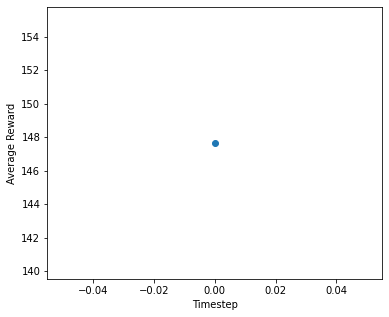

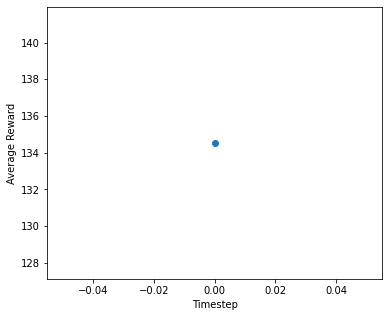

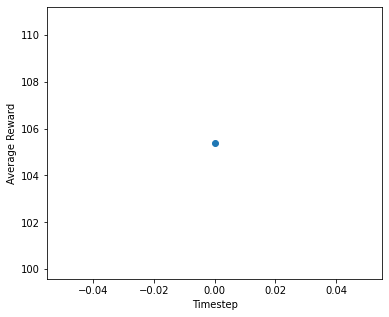

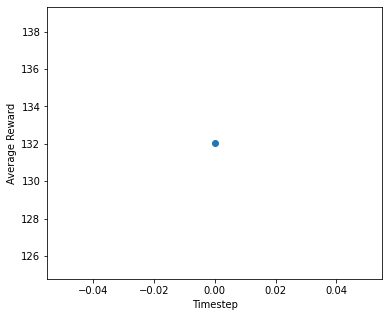

In [19]:
online_convex_algorithm = ExponentiatedGradient(lamb_max,2, eta, starting_lambda=starting_lambda)

for i in range(200):
    action,values=solve(np.array(lamb[-1]))
    actions.append(action)
    action_avg=sum(np.array(actions))/len(actions)
    lamb_avg=sum(np.array(lamb))/len(lamb)
    L_max=Lmax(action_avg)
    L_min=Lmin(solve(lamb_avg)[0],lamb_avg)
    print((L_max-L_min))
    if abs(L_max-L_min)<0.1:
        break
    gradient =( np.array(calc_G(action)) - np.array([0.01,0.01]))
    lambda_t = online_convex_algorithm.run(gradient)
    lamb.append(list(lambda_t))

In [20]:
lamb

[[500.0, 500.0],
 [998.8258450608176, 1.1741549391822128],
 [999.9969440368787, 0.003055963121268707]]

In [21]:
action=np.array([0,0,0,1,0,1,0,0,1,1,1,1,1,0,0,1,0,0,0,1,1,0,0,0])
checkFea(action)

(0.14285714285714285, 0.0)

In [22]:
a = 10*(np.load('rateListUsersYahoo.npy')[0]-np.load('rateListUsersYahoo.npy')[0].min())
a /= np.linalg.norm(a, ord=2)
100*((action>0.5).dot(a))

249.24654627101907

In [26]:
calc_G(action)

[0 0 0 1 0 1 0 0 1 1 1 1 1 0 0 1 0 0 0 1 1 0 0 0]


(0.14285714285714285, 0.0)

In [25]:

class para:
    def __init__(self):
        self.batch_size=16
        self.wmc=10
        self.solDim=24
        self.card=10
        self.test_batch_size=1000
        self.epochs=10
        self.lr=0.1
        self.momentum=0.5
        self.no_cuda='store_true'
        self.seed=1
        self.log_interval=10
        self.hidden_dim=10
        self.env='lake'
        self.headless='store_true'
args=para()

env_name=args.env
headless=args.headless
model_dir = os.path.join(os.getcwd(), 'models')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
###

#### Get a decent policy. 
#### Called pi_old because this will be the policy we use to gather data
policy_old = None
old_policy_path = os.path.join(model_dir, old_policy_name)

policy_old =solve_copy()

    # if env_name == 'car':
    #     try:
    #         # using old style model. This can be deleted if not using provided .h5 file 
    #         policy_old.Q.all_actions_func = K.function([self.model.get_layer('inp').input], [self.model.get_layer('dense_2').output])
    #     except:
    #         pass

# import pdb; pdb.set_trace()

#### Problem setup
if env_name == 'lake':
    best_response_algorithm = solve_copy()
    fitted_off_policy_evaluation_algorithm = solve_copy()
    exact_policy_algorithm = ExactPolicyEvaluator(action_space_map, gamma, env=env, frame_skip=frame_skip, num_frame_stack=num_frame_stack, pic_size = pic_size)
else:
    raise

online_convex_algorithm = ExponentiatedGradient(lambda_bound, len(constraints), eta, starting_lambda
=starting_lambda)
exploratory_policy_old = solve_copy()
problem = Program(constraints, 
                  action_space_dim, 
                  best_response_algorithm, 
                  online_convex_algorithm, 
                  fitted_off_policy_evaluation_algorithm, 
                  exact_policy_algorithm, 
                  lambda_bound, 
                  epsilon, 
                  env, 
                  max_number_of_main_algo_iterations,
                  num_frame_stack,
                  pic_size,)    

lambdas = []
policies = []
lambda_t=0
# print exact_policy_algorithm.run(policy_old.Q, to_monitor=True)

#### Collect Data
try:
    print ('Loading Prebuilt Data')
    tic = time.time()
    # problem.dataset.data = dd.io.load('%s_data.h5' % env_name)
    # print 'Loaded. Time elapsed: %s' % (time.time() - tic)
    # num of times breaking  + distance to center of track + zeros
    if env_name == 'car': 
        tic = time.time()
        action_data = dd.io.load('./seed_2_data/car_data_actions_seed_2.h5')
        frame_data = dd.io.load('./seed_2_data/car_data_frames_seed_2.h5')
        done_data = dd.io.load('./seed_2_data/car_data_is_done_seed_2.h5')
        next_state_data = dd.io.load('./seed_2_data/car_data_next_states_seed_2.h5')
        current_state_data = dd.io.load('./seed_2_data/car_data_prev_states_seed_2.h5')
        cost_data = dd.io.load('./seed_2_data/car_data_rewards_seed_2.h5')

        frame_gray_scale = np.zeros((len(frame_data),96,96)).astype('float32')
        for i in range(len(frame_data)):
            frame_gray_scale[i,:,:] = np.dot(frame_data[i,:,:,:]/255. , [0.299, 0.587, 0.114])

        problem.dataset.data = {'frames':frame_gray_scale,
                    'prev_states': current_state_data,
                    'next_states': next_state_data,
                    'a': action_data,
                    'c':cost_data[:,0],
                    'g':cost_data[:,1:],
                    'done': done_data
                    }

        problem.dataset.data['g'] = problem.dataset.data['g'][:,constraints_cared_about]
        # problem.dataset.data['g'] = (problem.dataset.data['g'] >= constraint_thresholds[:-1]).astype(int)
        print( 'Preprocessed g. Time elapsed: %s' % (time.time() - tic))
    else:
      raise 
except:
    print ('Recreating dataset')
    num_goal = 0
    num_hole = 0
    dataset_size = 0 
    main_tic = time.time()
    # from layer_visualizer import LayerVisualizer; LV = LayerVisualizer(exploratory_policy_old.policy.Q.model)
    for i in range(max_epochs):
        tic = time.time()
        x = env.reset()
        problem.collect(x, start=True)
        dataset_size += 1
        if env_name in ['car']:  env.render()
        done = False
        time_steps = 0
        episode_cost = 0
        while not done:
            time_steps += 1
            #LV.display_activation([problem.dataset.current_state()[np.newaxis,...], np.atleast_2d(np.eye(12)[0])], 2, 2, 0)
            action,costs = exploratory_policy_old(lambda_t)
            cost = []
            for _ in range(frame_skip):
                if env_name in ['car']: env.render()
                a = 10*(np.load('rateListUsersYahoo.npy')[0]-np.load('rateListUsersYahoo.npy')[0].min())
                a /= np.linalg.norm(a, ord=2)
                done=1
                yu=torch.unbind(torch.from_numpy(np.array(action)))
                xu = torch.unbind(torch.from_numpy(np.array([0.02]*24).astype(np.float32)))
                wmc = cmpe.get_torch_ac([[1.0 - ny,ny] for ny in yu + xu]) 
                x_prime=action.copy()
                
                cost.append(costs)
                if done:
                    break
            cost = np.vstack([np.hstack(x) for x in cost]).sum(axis=0)
            early_done, punishment = env.is_early_episode_termination(cost=cost[0], time_steps=time_steps, total_cost=episode_cost)
            # print cost, action_space_map[action] #env.car.fuel_spent/ENGINE_POWER, env.tile_visited_count, len(env.track), env.tile_visited_count/float(len(env.track))
            done = done or early_done

            # if done and reward: num_goal += 1
            # if done and not reward: num_hole += 1
            episode_cost += cost[0] + punishment
            c = (cost[0] + punishment).tolist()
            g = cost[1:].tolist()
            if len(g) < len(constraints): g=np.hstack([g,0])
            problem.collect( action,
                             x_prime, #np.dot(x_prime/255. , [0.299, 0.587, 0.114]),
                             np.hstack([c,g]).reshape(-1).tolist(),
                             done
                             ) #{(x,a,x',c(x,a), g(x,a)^T, done)}
            dataset_size += 1
            x = x_prime
        if (i % 1) == 0:
            #print ('Epoch: %s. Exploration probability: %s' % (i, np.round(exploratory_policy_old.epsilon,5), ) )
            print( 'Dataset size: %s Time Elapsed: %s. Total time: %s' % (dataset_size, time.time() - tic, time.time()-main_tic))
            if env_name in ['car']: 
                print ('Performance: %s/%s = %s' %  (env.tile_visited_count, len(env.track), env.tile_visited_count/float(len(env.track))))
            print( '*'*20 )
    problem.finish_collection(env_name)

if env_name in ['lake']:
    problem.dataset['x'] = problem.dataset['frames'][problem.dataset['prev_states']]
    problem.dataset['x_prime'] = problem.dataset['frames'][problem.dataset['next_states']]
    problem.dataset['g'] = problem.dataset['g'][:,0:1]
    print( 'x Distribution:' )
    print (np.histogram(problem.dataset['x'], bins=np.arange(map_size**2+1)-.5)[0].reshape(map_size,map_size))

    print( 'x_prime Distribution:' )
    print (np.histogram(problem.dataset['x_prime'], bins=np.arange(map_size**2+1)-.5)[0].reshape(map_size,map_size))

    print ('Number episodes achieved goal: %s. Number episodes fell in hole: %s' % (-problem.dataset['c'].sum(axis=0), problem.dataset['g'].sum(axis=0)[0]))
    number_of_total_state_action_pairs = (state_space_dim-np.sum(env.desc=='H')-np.sum(env.desc=='G'))*action_space_dim
    number_of_state_action_pairs_seen = len(np.unique(np.hstack([problem.dataset['x'].reshape(1,-1).T, problem.dataset['a'].reshape(1,-1).T]),axis=0))
    print( 'Percentage of State/Action space seen: %s' % (number_of_state_action_pairs_seen/float(number_of_total_state_action_pairs)))
# print 'C(pi_old): %s. G(pi_old): %s' % (exact_policy_algorithm.run(exploratory_policy_old,policy_is_greedy=False, to_monitor=True) )
### Solve Batch Constrained Problem

iteration = 0
while not problem.is_over(policies, lambdas, infinite_loop=infinite_loop, calculate_gap=calculate_gap, results_name=results_name, policy_improvement_name=policy_improvement_name):
    iteration += 1
    K.clear_session()
    for i in range(1):

        # policy_printer.pprint(policies)
        print( '*'*20)
        print ('Iteration %s, %s' % (iteration, i))
        if len(lambdas) == 0:
            # first iteration
            lambdas.append(online_convex_algorithm.get())
            print ('lambda_{0}_{2} = {1}'.format(iteration, lambdas[-1], i))
        else:
            # all other iterations
            lambda_t = problem.online_algo()
            lambdas.append(lambda_t)
            print ('lambda_{0}_{3} = online-algo(pi_{1}_{3}) = {2}'.format(iteration, iteration-1, lambdas[-1], i))

        lambda_t = lambdas[-1]
        pi_t,values  = problem.best_response(lambda_t)
        # policies.append(pi_t)
        problem.update(pi_t, values, iteration) #Evaluate C(pi_t), G(pi_t) and save


Loading Prebuilt Data
Recreating dataset


AttributeError: 'int' object has no attribute 'dot'

In [ ]:
action